# Preparing and Enriching the Million Playlist Dataset

In [1]:
import time
import math
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from os import listdir
from os.path import isfile, join
sns.set()

from itertools import chain

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials 

client_id = ""
client_secret = ""

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## Data Source

We began our work with the Million Playlist Dataset. This data set was prepared as part of the [RecSys Challenge 2018](https://recsys-challenge.spotify.com/) organized by Spotify, University of Massachusetts (Amherst), and Johannes Kepler University (Linz).

The raw data includes:

- 1,000 CSV files, totaling 11.63 GB
- Each CSV file has 1,000 playlists, each with a collection of approximately 50-200 songs
- ~65,000 songs in each CSV file, ~65,000,000 total observations (including duplicates) 

The initial provided data features include:

- **Playlist Number:** integer value ranging from 0 to 999 within each CSV file
- **Track Position:** integer value starting from 0 indicating the position of the song in the playlist
- **Track Name:** text value
- **Track URI:** alphanumeric identifier from Spotify
- **Artist Name:** text value
- **Artist URI:** alphanumeric identifier from Spotify
- **Album Name:** text value
- **Album URI:** alphanumeric identifier from Spotify
- **Duration:** integer value in milliseconds

Here is a sample of the provided data.

In [4]:
# display a sample CSV file
df = pd.read_csv('../data/Songs/songs285.csv')
print("Shape of data in CSV file:", df.shape)
display(df.head())

Shape of data in CSV file: (64928, 9)


pid  pos            artist_name                             track_uri  \
0    0    0               Deftones  spotify:track:4rEGJ9KirDlKiOHxqVwcVg   
1    0    1                   Muse  spotify:track:0It6VJoMAare1zdV2wxqZq   
2    0    2              Pearl Jam  spotify:track:0LBmvPJYmtEJ7kkWvc3kbT   
3    0    3    My Chemical Romance  spotify:track:0uukw2CgEIApv4IWAjXrBC   
4    0    4  Red Hot Chili Peppers  spotify:track:1iFIZUVDBCCkWe705FLXto   

                              artist_uri           track_name  \
0  spotify:artist:6Ghvu1VvMGScGpOUJBAHNH              Sextape   
1  spotify:artist:12Chz98pHFMPJEknJQMWvI  Undisclosed Desires   
2  spotify:artist:1w5Kfo2jwwIPruYS2UWh56               Oceans   
3  spotify:artist:7FBcuc1gsnv6Y1nwFtNRCb                Dead!   
4  spotify:artist:0L8ExT028jH3ddEcZwqJJ5                Dosed   

                              album_uri  duration_ms        album_name  
0  spotify:album:4RQnFSkkZlA65Xxchhnaha       241533      Diamond Eyes  
1  spotify:album:0eFHYz8NmK75zSplL5qlfM       235000    The Resistance  
2  spotify:album:5B4PYA7wNN4WdEXdIJu58a       161893               Ten  
3  spotify:album:0FZK97MXMm5mUQ8mtudjuK       195520  The Black Parade  
4  spotify:album:6deiaArbeoqp1xPEGdEKp1       311866        By The Way

## Data Structuring

For songs that appear in multiple playlists, data in each of the columns are repeated. This produces a total of 11.63 GB of data, a significant computational challenge. A reasonable first step to slim down the size of the dataset without losing information or fidelity is to parse through all the files to create a reference table of all songs and their metadata. Each playlist can then be stored as a simple named object, where the name is the ID of the playlist and its value a vector of song IDs.

From this exercise, we output two data frames:

- **Songs table:** Pandas dataframe with all songs as rows and all data from individual CSV files as columns
- **Playlists series:** Pandas series with playlist IDs as indices and vectors of song IDs as items

Running this over the entire dataset has a run-time of 2.5 hours. This method of storing songs in a dedicated table reduces 65 million song observations to just 2.5 million unique songs. To make this computationally tractable, we leveraged Pandas data frames and the fact that their indices, if sorted and maintained properly, leverage hash tables for quick lookups. This is in contrast to using a base Python method like loops or list comprehension, which would require searching the full table for the song each time. This reduced the overall data scale from 11.63 GB to just 0.42 GB for the songs master table and 0.54 GB for the playlist vectors, a total that is less than 10% the original size with no information loss. Our efforts in complexity reduction enabled us to perform our modeling at a significantly larger scale and use more data to generate better recommendations.

In [1]:
# Looping over 200,000 random playlists to fill out a master Pandas dataframe for songs and a Pandas series for playlists

start_time = time.time()
loop_start = time.time()

# List of all files
all_files = listdir('../data/Songs')
# 200,000 playlists is plenty
all_files = all_files[0:200]

# Load first file to get columns (standard across all)
df = pd.read_csv('../data/Songs/' + all_files[0])

# Master DataFrame of all unique songs included across all playlists
#songs = pd.DataFrame(columns = list(df.columns)[2:])
songs = pd.DataFrame()

# Master Series of playlists and the songs included in each
playlists = pd.Series()

# Aggregator functions to limit to one row per song and count occurrences across playlists
a1 = dict()
for key in df.columns[2:]:
    a1[key] = 'first'
a1['track_uri'] = 'count'

# Aggregator to consolidate into sum of songs across playlists
a2= dict()
for key in df.columns[2:]:
    a2[key] = 'first'
del a2['track_uri']
a2['count'] = 'sum'

# Loop over each file to extract data
for i, file in enumerate(all_files):
    # split on "." to split into "filename" and "csv"
    # Then select "filename" and ditch the first five letters "songs"
    filenum = file.split(".")[0][5:]
    
    # Load file and store in temporary dataframe
    fdf = pd.read_csv('../data/Songs/' + file)
    
    # --- SONGS IN FILE ---
    fdf_counts = fdf.iloc[:, 2:]
    fdf_counts = fdf_counts.groupby('track_uri').agg(a1)
    fdf_counts.rename(columns = {'track_uri': 'count'}, inplace = True)
    
    # Add to df of unique songs, update counters, and remove duplicates
    songs = songs.append(fdf_counts)
    
    # -- SONGS IN EACH PLAYLIST --
    # Songs included in every playlist (ordered) in file
    # For each playlist, get list of track_uri's (unique identifiers)
    songs_in_playlist = fdf.groupby('pid')['track_uri'].unique()

    # Update index to be not the pid in file (id), but a combination of them
    #songs_in_playlist.index = [filenum + '_' + str(pid) for pid in songs_in_playlist.index.values]
    songs_in_playlist.index = list(map(lambda x: filenum + '_' + str(x), songs_in_playlist.index.values))
    
    # Add playlists to master Series of all playlists
    playlists = playlists.append(songs_in_playlist)
    
    # Every 50 files, consolidate the songs table so it doesn't grow too big
    if (i+1)%25 == 0: 
        print('{}/{} -- {} s'.format(i+1, len(all_files), time.time() - loop_start))
        loop_start = time.time()
        songs = songs.groupby('track_uri').agg(a2, sort = True)
        print('   Consolidation: {} s'.format(time.time() - loop_start))
    
print("--- %s seconds ---" % (time.time() - start_time))

In [2]:
# Looping over all files to fill out a master Pandas dataframe for songs and a Pandas series for playlists

start_time = time.time()
loop_start = time.time()

# List of all files
all_files = listdir('../data/Songs')
# Limit to some of the playlists
#all_files = all_files[0:200]

# Load first file to get columns (standard across all)
df = pd.read_csv('../data/Songs/' + all_files[0])

# Master DataFrame of all unique songs included across all playlists
#songs = pd.DataFrame(columns = list(df.columns)[2:])
songs = pd.DataFrame()

# Master Series of playlists and the songs included in each
playlists = pd.Series()

# Aggregator functions to limit to one row per song and count occurrences across playlists
a1 = dict()
for key in df.columns[2:]:
    a1[key] = 'first'
a1['track_uri'] = 'count'

# Aggregator to consolidate into sum of songs across playlists
a2= dict()
for key in df.columns[2:]:
    a2[key] = 'first'
del a2['track_uri']
a2['count'] = 'sum'

# Loop over each file to extract data
for i, file in enumerate(all_files):
    # split on "." to split into "filename" and "csv"
    # Then select "filename" and ditch the first five letters "songs"
    filenum = file.split(".")[0][5:]
    
    # Load file and store in temporary dataframe
    fdf = pd.read_csv('../data/Songs/' + file)
    
    # --- SONGS IN FILE ---
    fdf_counts = fdf.iloc[:, 2:]
    fdf_counts = fdf_counts.groupby('track_uri').agg(a1)
    fdf_counts.rename(columns = {'track_uri': 'count'}, inplace = True)
    
    # Add to df of unique songs, update counters, and remove duplicates
    songs = songs.append(fdf_counts)
    
    # -- SONGS IN EACH PLAYLIST --
    # Songs included in every playlist (ordered) in file
    # For each playlist, get list of track_uri's (unique identifiers)
    songs_in_playlist = fdf.groupby('pid')['track_uri'].unique()

    # Update index to be not the pid in file (id), but a combination of them
    #songs_in_playlist.index = [filenum + '_' + str(pid) for pid in songs_in_playlist.index.values]
    songs_in_playlist.index = list(map(lambda x: filenum + '_' + str(x), songs_in_playlist.index.values))
    
    # Add playlists to master Series of all playlists
    playlists = playlists.append(songs_in_playlist)
    
    # Every 50 files, consolidate the songs table so it doesn't grow too big
    if (i+1)%25 == 0: 
        print('{}/{} -- {} s'.format(i+1, len(all_files), time.time() - loop_start))
        loop_start = time.time()
        songs = songs.groupby('track_uri').agg(a2, sort = True)
        print('   Consolidation: {} s'.format(time.time() - loop_start))
    
print("--- %s seconds ---" % (time.time() - start_time))

Once we have our master dataframe with all unique songs, we can assign an ID to each song, which we do as a new column at the end of the below dataframe labeled `song_id`.

In [18]:
# Do a final consolidation and add song ID to table
start_time = time.time()
songs_counts = songs.groupby('track_uri').agg(a2)
songs_counts['song_id'] = np.arange(len(songs_counts))
print("--- %s seconds ---" % (time.time() - start_time))

print(songs_counts.shape)
display(songs_counts.head())

--- 7.567456960678101 seconds ---
(1003760, 8)


artist_name  \
track_uri                                                                 
spotify:track:0002yNGLtYSYtc0X6ZnFvp  Sidney Bechet's Blue Note Jazzmen   
spotify:track:00039MgrmLoIzSpuYKurn9                        Zach Farlow   
spotify:track:0006Rv1e2Xfh6QooyKJqKS                Two Steps from Hell   
spotify:track:0007AYhg2UQbEm88mxu7js                        Little Simz   
spotify:track:0009mEWM7HILVo4VZYtqwc                               Slam   

                                                                 artist_uri  \
track_uri                                                                     
spotify:track:0002yNGLtYSYtc0X6ZnFvp  spotify:artist:2XouUSO0EAJ9gMMoHiXqMt   
spotify:track:00039MgrmLoIzSpuYKurn9  spotify:artist:2jTojc4rAsOMx6200a8Ah1   
spotify:track:0006Rv1e2Xfh6QooyKJqKS  spotify:artist:2qvP9yerCZCS0U1gZU8wYp   
spotify:track:0007AYhg2UQbEm88mxu7js  spotify:artist:6eXZu6O7nAUA5z6vLV8NKI   
spotify:track:0009mEWM7HILVo4VZYtqwc  spotify:artist:0Y0Kj7BOR5DM0UevuY7IvO   

                                                   track_name  \
track_uri                                                       
spotify:track:0002yNGLtYSYtc0X6ZnFvp           Muskrat Ramble   
spotify:track:00039MgrmLoIzSpuYKurn9           Thas What I Do   
spotify:track:0006Rv1e2Xfh6QooyKJqKS                Nightwood   
spotify:track:0007AYhg2UQbEm88mxu7js  Mandarin Oranges Part 2   
spotify:track:0009mEWM7HILVo4VZYtqwc                 Movement   

                                                                 album_uri  \
track_uri                                                                    
spotify:track:0002yNGLtYSYtc0X6ZnFvp  spotify:album:04hQBJ7YSuNnZ0nbuXNYbY   
spotify:track:00039MgrmLoIzSpuYKurn9  spotify:album:0UHfgx3ITlxePDXLaN5Y6x   
spotify:track:0006Rv1e2Xfh6QooyKJqKS  spotify:album:1BD29pKydSXe1EsHFj0GrQ   
spotify:track:0007AYhg2UQbEm88mxu7js  spotify:album:32RJzqlapfiU0fr2l4SSW9   
spotify:track:0009mEWM7HILVo4VZYtqwc  spotify:album:62VkRE2ucNvZDnYMCsnNDh   

                                      duration_ms  \
track_uri                                           
spotify:track:0002yNGLtYSYtc0X6ZnFvp       220293   
spotify:track:00039MgrmLoIzSpuYKurn9       222727   
spotify:track:0006Rv1e2Xfh6QooyKJqKS       189638   
spotify:track:0007AYhg2UQbEm88mxu7js       198000   
spotify:track:0009mEWM7HILVo4VZYtqwc       447534   

                                                        album_name  count  \
track_uri                                                                   
spotify:track:0002yNGLtYSYtc0X6ZnFvp                 Jazz Classics      1   
spotify:track:00039MgrmLoIzSpuYKurn9            The Great Escape 2      2   
spotify:track:0006Rv1e2Xfh6QooyKJqKS  Colin Frake On Fire Mountain      4   
spotify:track:0007AYhg2UQbEm88mxu7js                       E.D.G.E      1   
spotify:track:0009mEWM7HILVo4VZYtqwc                      Movement      1   

                                      song_id  
track_uri                                      
spotify:track:0002yNGLtYSYtc0X6ZnFvp        0  
spotify:track:00039MgrmLoIzSpuYKurn9        1  
spotify:track:0006Rv1e2Xfh6QooyKJqKS        2  
spotify:track:0007AYhg2UQbEm88mxu7js        3  
spotify:track:0009mEWM7HILVo4VZYtqwc        4

With our generated `song_id`, we replace the `track_uri` in each playlist and switch `song_id` to become the new index column. This allows us to make faster lookups using `song_id` in our future work.

In [61]:
# Replace playlist track_uri with song_id

start_time = time.time()
loop_start = time.time()

playlists_songids = pd.Series(index = playlists.index)
playlists_songids = playlists_songids.astype(object)

i = 0
for ind, row in playlists.items():
    songids = np.array(songs_counts.loc[row, 'song_id'], 'int')
    playlists_songids.loc[str(ind)] = songids
    
    i += 1
    if i % (len(playlists)/20) == 0 == 0: 
        print('{}/{} -- {} s'.format(i, int(len(playlists)), time.time() - loop_start))
        loop_start = time.time()
    
print("--- %s seconds ---" % (time.time() - start_time))

print(playlists_songids.shape)
print(playlists_songids.head())

10000/200000 -- 38.7440550327301 s
20000/200000 -- 43.11882281303406 s
30000/200000 -- 44.18085217475891 s
40000/200000 -- 48.200636863708496 s
50000/200000 -- 52.817174196243286 s
60000/200000 -- 50.61113619804382 s
70000/200000 -- 57.99031400680542 s
80000/200000 -- 64.7493839263916 s
90000/200000 -- 67.53792810440063 s
100000/200000 -- 67.3009626865387 s
110000/200000 -- 68.4447910785675 s
120000/200000 -- 71.28671312332153 s
130000/200000 -- 72.44740080833435 s
140000/200000 -- 77.3995201587677 s
150000/200000 -- 80.82779884338379 s
160000/200000 -- 358.95413088798523 s
170000/200000 -- 90.39383912086487 s
180000/200000 -- 89.62128067016602 s
190000/200000 -- 100.55844020843506 s
200000/200000 -- 97.31215310096741 s
--- 1642.5336339473724 seconds ---
(200000,)
284_0    [340039, 125250, 881533, 653897, 49614, 356319...
284_1    [738782, 7646, 142078, 900881, 533258, 429837,...
284_2    [552361, 135177, 507876, 865927, 638474, 55164...
284_3    [214695, 27387, 700562, 448130, 1000188

In [62]:
# Change songs table to have song_id as index and track_uri as column
# We will be doing lookups on song_id while running

songs_counts_id = songs_counts.copy()
songs_counts_id['track_uri'] = songs_counts_id.index.values
songs_counts_id.set_index('song_id', inplace = True)
songs_counts_id.head()

artist_name  \
song_id                                      
0        Sidney Bechet's Blue Note Jazzmen   
1                              Zach Farlow   
2                      Two Steps from Hell   
3                              Little Simz   
4                                     Slam   

                                    artist_uri               track_name  \
song_id                                                                   
0        spotify:artist:2XouUSO0EAJ9gMMoHiXqMt           Muskrat Ramble   
1        spotify:artist:2jTojc4rAsOMx6200a8Ah1           Thas What I Do   
2        spotify:artist:2qvP9yerCZCS0U1gZU8wYp                Nightwood   
3        spotify:artist:6eXZu6O7nAUA5z6vLV8NKI  Mandarin Oranges Part 2   
4        spotify:artist:0Y0Kj7BOR5DM0UevuY7IvO                 Movement   

                                    album_uri  duration_ms  \
song_id                                                      
0        spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       220293   
1        spotify:album:0UHfgx3ITlxePDXLaN5Y6x       222727   
2        spotify:album:1BD29pKydSXe1EsHFj0GrQ       189638   
3        spotify:album:32RJzqlapfiU0fr2l4SSW9       198000   
4        spotify:album:62VkRE2ucNvZDnYMCsnNDh       447534   

                           album_name  count  \
song_id                                        
0                       Jazz Classics      1   
1                  The Great Escape 2      2   
2        Colin Frake On Fire Mountain      4   
3                             E.D.G.E      1   
4                            Movement      1   

                                    track_uri  
song_id                                        
0        spotify:track:0002yNGLtYSYtc0X6ZnFvp  
1        spotify:track:00039MgrmLoIzSpuYKurn9  
2        spotify:track:0006Rv1e2Xfh6QooyKJqKS  
3        spotify:track:0007AYhg2UQbEm88mxu7js  
4        spotify:track:0009mEWM7HILVo4VZYtqwc

In [ ]:
# Save data as CSV and PKL files

songs_counts_id.to_csv('../data/songs_counts_'+str(len(all_files))+'.csv')
songs_counts_id.to_pickle('../data/songs_counts_'+str(len(all_files))+'.pkl')

playlists_songids.to_csv('../data/playlists_song_ids_'+str(len(all_files))+'.csv', header = False)
playlists_songids.to_pickle('../data/playlists_song_ids_'+str(len(all_files))+'.pkl')

## Enriching a Song's Musical Features

Our recommendation hypothesis is that song features provide a data-based way of determining similarity and thus good matches to our seed songs. We leverage Spotify's open API to retrieve these musical features and add it into our dataset using Spotipy, a lightweight Python library that allows us to authenticate to Spotify and easily query features on the song, artist, and album. 

To keep Spotify API requests reasonable, we randomly selected 200,000 playlists (out of the total 1,000,000). Across these 200,000 playlists, we have 1,003,760 unique songs. We pull the data listed below for songs, artists, and albums from the Spotify API. Descriptions here are directly from [Spotify API reference documentation](https://developer.spotify.com/documentation/web-api/reference/).

#### Song features
- **acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- **energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- **instrumentalness:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- **key:** The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
- **liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- **loudness:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- **mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- **speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- **tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- **time_signature:** An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
- **valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

#### Artist features
- **artist_genres:** A list of the genres the artist is associated with. For example: "Prog Rock" , "Post-Grunge". (If not yet classified, the array is empty.)
- **artist_popularity:** The popularity of the artist. The value will be between 0 and 100, with 100 being the most popular. The artist’s popularity is calculated from the popularity of all the artist’s tracks.

#### Album features
- **album_genres:** A list of the genres used to classify the album. For example: "Prog Rock" , "Post-Grunge". (If not yet classified, the array is empty.)
- **album_popularity:** The popularity of the album. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated from the popularity of the album’s individual tracks.
- **release_date:** The date the album was first released. 

In [ ]:
# Enrich data with new track features from Spotify API

# read songs table
df = pd.read_pickle('../data/songs_counts_200.pkl')

# define batches
batch_size = 100
num_batches = math.ceil(len(df)/batch_size)

# initialize list to save API calls
track_features = []

start_time = time.time()

# looping through the batches
for i in range(num_batches):
    
    
    # define start and end of the batch
    start_point = i*batch_size
    end_point = min(start_point + batch_size, len(df))
    
    # API call
    track_list = list(df['track_uri'][start_point:end_point])
    track_features.extend(sp.audio_features(track_list))

    if i%100 == 0:
        print('{}/{}, {}s'.format(i, num_batches, time.time()-start_time))
        start_time = time.time()

# convert to dataframe
track_features_df = pd.DataFrame(track_features)

# save data
track_features_df.to_csv('../data/track_features.csv')
track_features_df.to_pickle('../data/track_features.pkl')

In [ ]:
# Enrich data with new artist features from Spotify API

# identify unique artists
unique_artists = list(df['artist_uri'].unique())

# define batches
batch_size = 50
num_batches = math.ceil(len(unique_artists)/batch_size)

# initialize list to save API calls
artist_info = []

start_time = time.time()

# looping through the batches
for i in range(num_batches):
    
    
    # define start and end of the batch
    start_point = i*batch_size
    end_point = min(start_point + batch_size, len(df))
    
    # API call
    artist_list = unique_artists[start_point:end_point]
    artist_info.extend(sp.artists(artist_list)['artists'])

    if i%100 == 0:
        print('{}/{}, {}s'.format(i, num_batches, time.time()-start_time))
        start_time = time.time()

# convert to dataframe
artist_info_df = pd.DataFrame(artist_info)

# save data
artist_info_df.to_csv('../data/artist_info.csv')
artist_info_df.to_pickle('../data/artist_info.pkl')

In [ ]:
# Enrich data with new album features from Spotify API

# identify unique albums
unique_albums = list(df['album_uri'].unique())

# define batches
batch_size = 20
num_batches = math.ceil(len(unique_albums)/batch_size)

# initialize list to save API calls
album_info = []

start_time = time.time()

# looping through the batches
for i in range(num_batches):
    
    
    # define start and end of the batch
    start_point = i*batch_size
    end_point = min(start_point + batch_size, len(df))
    
    # API call
    album_list = unique_albums[start_point:end_point]
    album_info.extend(sp.albums(album_list)['albums'])

    if i%100 == 0:
        print('{}/{}, {}s'.format(i, num_batches, time.time()-start_time))
        start_time = time.time()
        
# eliminates none values
album_info = [i for i in album_info if i is not None]

# convert to dataframe
album_info_df = pd.DataFrame(album_info)

# save data
album_info_df.to_csv('../data/album_info.csv')
album_info_df.to_pickle('../data/album_info.pkl')

After pulling data from the Spotify API, we have a dataset of 999,950 unique songs and their associated metadata. We join our retrieved features back into the master tables to produce our final data frames below. We conclude by saving our transformed data into pickle files, which provides faster and more compact files for checkpoint saving.

#### Enriched Tracks Dataframe

In [130]:
# import data
track_columns = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','uri']
tracks = pd.read_csv('../data/track_features3.csv', usecols=track_columns)

# rename columns for clarity
tracks = tracks.rename(columns={'uri': 'track_uri'})
tracks = tracks.drop_duplicates()

tracks

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0               0.455   0.623    8   -11.572     1       0.0523      0.797000   
1               0.742   0.753    1    -5.632     1       0.0364      0.017800   
2               0.295   0.498    2    -9.190     0       0.0301      0.795000   
3               0.648   0.598    7   -11.845     1       0.3260      0.164000   
4               0.695   0.828    1    -6.818     1       0.0457      0.000007   
...               ...     ...  ...       ...   ...          ...           ...   
1003729         0.447   0.724    1    -6.398     0       0.0372      0.788000   
1003730         0.497   0.698    7    -2.558     1       0.0317      0.127000   
1003731         0.314   0.359    0   -14.035     1       0.0378      0.745000   
1003732         0.769   0.644   11    -5.568     0       0.0997      0.242000   
1003733         0.624   0.851    9    -4.254     1       0.0723      0.095800   

         instrumentalness  liveness  valence    tempo  \
0                0.903000    0.6340   0.9510  182.345   
1                0.000000    0.1330   0.2630  132.064   
2                0.944000    0.1070   0.0445   89.048   
3                0.000046    0.1230   0.4000  138.883   
4                0.851000    0.1090   0.0372  126.014   
...                   ...       ...      ...      ...   
1003729          0.202000    0.2420   0.9400   81.071   
1003730          0.000000    0.1160   0.5520  129.996   
1003731          0.866000    0.6700   0.1030  131.911   
1003732          0.010200    0.0509   0.3960  103.014   
1003733          0.000000    0.0766   0.6930  128.030   

                                    track_uri  time_signature  
0        spotify:track:0002yNGLtYSYtc0X6ZnFvp               4  
1        spotify:track:00039MgrmLoIzSpuYKurn9               4  
2        spotify:track:0006Rv1e2Xfh6QooyKJqKS               3  
3        spotify:track:0007AYhg2UQbEm88mxu7js               4  
4        spotify:track:0009mEWM7HILVo4VZYtqwc               4  
...                                       ...             ...  
1003729  spotify:track:7zzptITgTKf4HpJM8ye47v               4  
1003730  spotify:track:7zzpwV2lgKsLke68yFoZdp               4  
1003731  spotify:track:7zzrUgpSu2MSZF4FecBN3D               4  
1003732  spotify:track:7zzuTn6PnJ1DVfAiGsd4N0               4  
1003733  spotify:track:7zzxEH0xUl5k3p6IxUfgAO               4  

[1003734 rows x 13 columns]

#### Enriched Artists Dataframe

In [129]:
# import data
artist_columns = ['genres','popularity','uri']
artists = pd.read_csv('../data/artist_info1.csv', usecols=artist_columns)

# rename columns for clarity
artists = artists.rename(columns={'genres': 'artist_genres', 'popularity': 'artist_popularity', 'uri': 'artist_uri'})
artists = artists.drop_duplicates()

artists

artist_genres  artist_popularity  \
0                                                      []                 18   
1                                                      []                 27   
2       ['epicore', 'scorecore', 'soundtrack', 'video ...                 70   
3       ['alternative r&b', 'escape room', 'indie r&b'...                 63   
4       ['acid techno', 'minimal dub', 'minimal techno...                 39   
...                                                   ...                ...   
149667                                                 []                 12   
149668                                                 []                 15   
149669                           ['dub reggae', 'uk dub']                 15   
149670                                                 []                 17   
149671                                                 []                  9   

                                   artist_uri  
0       spotify:artist:2XouUSO0EAJ9gMMoHiXqMt  
1       spotify:artist:2jTojc4rAsOMx6200a8Ah1  
2       spotify:artist:2qvP9yerCZCS0U1gZU8wYp  
3       spotify:artist:6eXZu6O7nAUA5z6vLV8NKI  
4       spotify:artist:0Y0Kj7BOR5DM0UevuY7IvO  
...                                       ...  
149667  spotify:artist:2mRZOivAjsqp7VbLrjfL5g  
149668  spotify:artist:4Cx5NofT2E2Ypu32HP0Mot  
149669  spotify:artist:3RQFJaSRrhXQ2E9T8vZEe3  
149670  spotify:artist:7iihQll6y9O8Iee7D1uEcb  
149671  spotify:artist:3uCW660nT9zh4oF4WhlBCl  

[149133 rows x 3 columns]

#### Enriched Albums Dataframe

In [128]:
# import data
album_columns = ['genres','popularity','release_date','uri']

albums1 = pd.read_csv('../data/album_info1.csv', usecols=album_columns)
albums2 = pd.read_csv('../data/album_info2.csv', usecols=album_columns)
albums3 = pd.read_csv('../data/album_info3.csv', usecols=album_columns)
albums4 = pd.read_csv('../data/album_info4.csv', usecols=album_columns)
albums5 = pd.read_csv('../data/album_info5.csv', usecols=album_columns)
albums6 = pd.read_csv('../data/album_info6.csv', usecols=album_columns)
albums = pd.concat([albums1, albums2, albums3, albums4, albums5, albums6], axis=0, ignore_index=True)

# rename columns for clarity
albums = albums.rename(columns={'genres': 'album_genres', 'popularity': 'album_popularity', 'release_date': 'album_release_date', 'uri': 'album_uri'})
albums = albums.drop_duplicates()

albums

album_genres  album_popularity album_release_date  \
0                []                37         1993-01-01   
1                []                 0         2016-01-08   
2                []                41         2014-07-01   
3                []                33         2014-10-03   
4                []                 8         2013-08-26   
...             ...               ...                ...   
375441           []                33         2017-08-25   
375442           []                 0         2014-09-16   
375443           []                25         2016-06-29   
375444           []                22         1994-09-09   
375445           []                 0         2015-03-09   

                                   album_uri  
0       spotify:album:04hQBJ7YSuNnZ0nbuXNYbY  
1       spotify:album:0UHfgx3ITlxePDXLaN5Y6x  
2       spotify:album:1BD29pKydSXe1EsHFj0GrQ  
3       spotify:album:32RJzqlapfiU0fr2l4SSW9  
4       spotify:album:62VkRE2ucNvZDnYMCsnNDh  
...                                      ...  
375441  spotify:album:6Fnj40x1kkxtHK3icGVsqg  
375442  spotify:album:5lkHAkEZsMj2bvcAzzrJYz  
375443  spotify:album:2OhSv0hAHVqo5zIDaUDcQA  
375444  spotify:album:4WmaRhaV8rs1GOk1GX26j5  
375445  spotify:album:5BTzgzUsUtB55FsLXLpPaV  

[375446 rows x 4 columns]

#### Total and Complete Master Songs Data Frame

In [4]:
master = pd.read_pickle('../data/songs_counts_200.pkl')
master['song_id'] = master.index
master

In [132]:
master = master.merge(track_features, on='track_uri', suffixes=(None, '_tracks'))
master = master.merge(artists, on='artist_uri', suffixes=(None, '_artists'))
master = master.merge(albums, on='album_uri', suffixes=(None, '_albums'))
master = master.set_index('song_id')
master

artist_name  \
song_id                                      
0        Sidney Bechet's Blue Note Jazzmen   
159583                       Sidney Bechet   
271702                       Sidney Bechet   
445190                       Sidney Bechet   
626275                       Sidney Bechet   
...                                    ...   
1003684                        Royal Rizow   
1003707                        Moa Felicia   
1003733             The Commercial Hippies   
1003746                         Murray Man   
1003759                                D&B   

                                    artist_uri  \
song_id                                          
0        spotify:artist:2XouUSO0EAJ9gMMoHiXqMt   
159583   spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk   
271702   spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk   
445190   spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk   
626275   spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk   
...                                        ...   
1003684  spotify:artist:5eXba1Axr3YJgg5j8Hn7a8   
1003707  spotify:artist:2uB6FyYwjUENL072rdwu5B   
1003733  spotify:artist:4Cx5NofT2E2Ypu32HP0Mot   
1003746  spotify:artist:3RQFJaSRrhXQ2E9T8vZEe3   
1003759  spotify:artist:3uCW660nT9zh4oF4WhlBCl   

                                     track_name  \
song_id                                           
0                                Muskrat Ramble   
159583                             Blue Horizon   
271702   Blame It On The Blues - Alternate Take   
445190                               Summertime   
626275                       Dear Old Southland   
...                                         ...   
1003684     I'll Find a Way (feat. Ty Reynolds)   
1003707     Later That Night - Original Version   
1003733             The Antidote - Original Mix   
1003746                     Tell Me What a Gwan   
1003759                  Princesa De Mis Sueños   

                                    album_uri  duration_ms  \
song_id                                                      
0        spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       220293   
159583   spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       264933   
271702   spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       175893   
445190   spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       251906   
626275   spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       243693   
...                                       ...          ...   
1003684  spotify:album:3XWD2ACwxS3fnGGgu298eS       205346   
1003707  spotify:album:2ugoxa1ZsUKtbziD0SonBA       329032   
1003733  spotify:album:2UnJeq5hGlBFCcnQZZ2Va9       511639   
1003746  spotify:album:5p8thDxso3h80HbO5fTnL2       226813   
1003759  spotify:album:2Qv89jKrJtXf5SjThoJvHE       185577   

                                  album_name  count  \
song_id                                               
0                              Jazz Classics      1   
159583                         Jazz Classics      5   
271702                         Jazz Classics      1   
445190                         Jazz Classics     16   
626275                         Jazz Classics      1   
...                                      ...    ...   
1003684  I'll Find a Way (feat. Ty Reynolds)     11   
1003707            Later That Night - Single      1   
1003733                         The Antidote      1   
1003746                   The Early Releases      1   
1003759               Princesa De Mis Sueños      1   

                                    track_uri  danceability  energy  ...  \
song_id                                                              ...   
0        spotify:track:0002yNGLtYSYtc0X6ZnFvp         0.455   0.623  ...   
159583   spotify:track:1EWPMNHfdVNJwBpG9BcxXB         0.327   0.372  ...   
271702   spotify:track:26N4Y48EjprAtvlY6yWZTA         0.574   0.606  ...   
445190   spotify:track:3RlJx8xwZEyToSuGrygilr         0.608   0.138  ...   
626275   spotify:track:4qwAa1rOm8iaegHzoM1b31         0.400   0.320  ...   
...                                       ...           ...   

In [ ]:
master.to_csv('../data/master200.csv')
master.to_pickle('../data/master200.pkl')

# Explore Spotify's Song Data and Musical Features

Our enriched master tables provides us with fertile ground for exploratory data analysis as we seek to understand the playlist groupings and song features for all songs in the provided dataset. We start with 25 song features of interest.

In [3]:
import time
import math
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from os import listdir
from os.path import isfile, join
sns.set()

from itertools import chain

In [4]:
songs = pd.read_pickle('../../data/200_first_playlists/master200.pkl')
playlists = pd.read_pickle('../../data/200_first_playlists/playlists_song_ids_200.pkl')

In [8]:
musical_features = [f for f in songs.columns]
for i in range(len(musical_features)):
    print(f"{i+1}. {musical_features[i]}")

1. artist_name
2. artist_uri
3. track_name
4. album_uri
5. duration_ms
6. album_name
7. count
8. track_uri
9. danceability
10. energy
11. key
12. loudness
13. mode
14. speechiness
15. acousticness
16. instrumentalness
17. liveness
18. valence
19. tempo
20. time_signature
21. artist_genres
22. artist_popularity
23. album_genres
24. album_popularity
25. album_release_date


### Playlist Distributions

We begin by seeking to understand how many songs appear in each playlist as well as how many playlists each song appears in. There is a very strong right skew for song distribution, as a few songs appear in an enormously large number of playlists while the vast majority of songs appear in very few playlists overall. Because of this, we have filtered out songs that appear only once, or in more than 50 playlists, to present a more readable distribution.

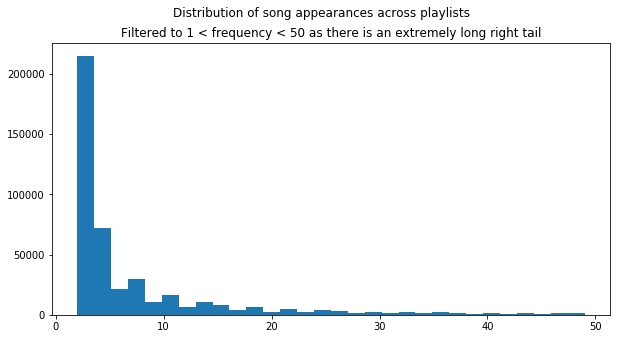

In [122]:
# Distribution of song appearances across playlists
plt.subplots(figsize=(10,5))
plt.hist(songs.loc[(songs['count'] > 1) & (songs['count'] < 50), 'count'], bins = 30)
plt.suptitle('Distribution of song appearances across playlists')
plt.title('Filtered to 1 < frequency < 50 as there is an extremely long right tail');

The median number of songs in a playlist is about 20, though this too has a long right tail. The maximum number of songs in a single playlist in our dataset is 341.

In [59]:
# Calculates length of longest and shortest playlists
playlist_lengths = [len(playlist) for playlist in playlists]
print("Largest playlist", max(playlist_lengths))
print("Smallest playlist: ", min(playlist_lengths))

Largest playlist 341
Smallest playlist:  3


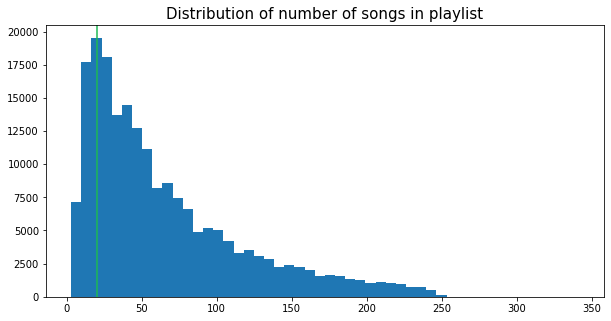

In [126]:
# Distribution of number of songs in playlist
plt.subplots(figsize=(10,5))
playlist_lengths = np.array([len(p) for p in playlists.values], 'int')
plt.hist(playlist_lengths, bins = 50)
plt.axvline(x=20, color="#1DB954")
plt.title('Distribution of number of songs in playlist', size=15);

For our newly enriched musical features, we leverage Seaborn distribution plots to understand the nature of each of these columns. Some have a relatively even distribution but even more appear to be centered around a small value. Song duration centers expectedly around 3-4 minutes, though there are a few songs with extremely long lengths. These are presumed to be songs in playlists related to sleep, where frequent switching is detrimental to a relaxing environment. Danceability, a critical feature in these author's opinions, centers around a score of 0.6 but energy has a left skew with a center around 0.8-0.9. Liveness, instrumentalness, speechiness and loudness all have fairly centered values with a few songs exhibiting different behaviors. The overall gathering of song features around a few feature values is an interesting takeaway.

In [12]:
print("The distribution plots below map to these columns:")
print("""
--------------------------------------------------
duration_ms | count             | danceability
--------------------------------------------------
energy      | tempo             | loudness
--------------------------------------------------
speechiness | acousticness      | instrumentalness
--------------------------------------------------
liveness    | artist_popularity | album_popularity
--------------------------------------------------
""")

The distribution plots below map to these columns:

--------------------------------------------------
duration_ms | count             | danceability
--------------------------------------------------
energy      | tempo             | loudness
--------------------------------------------------
speechiness | acousticness      | instrumentalness
--------------------------------------------------
liveness    | artist_popularity | album_popularity
--------------------------------------------------



Time elapsed: 3.9 seconds


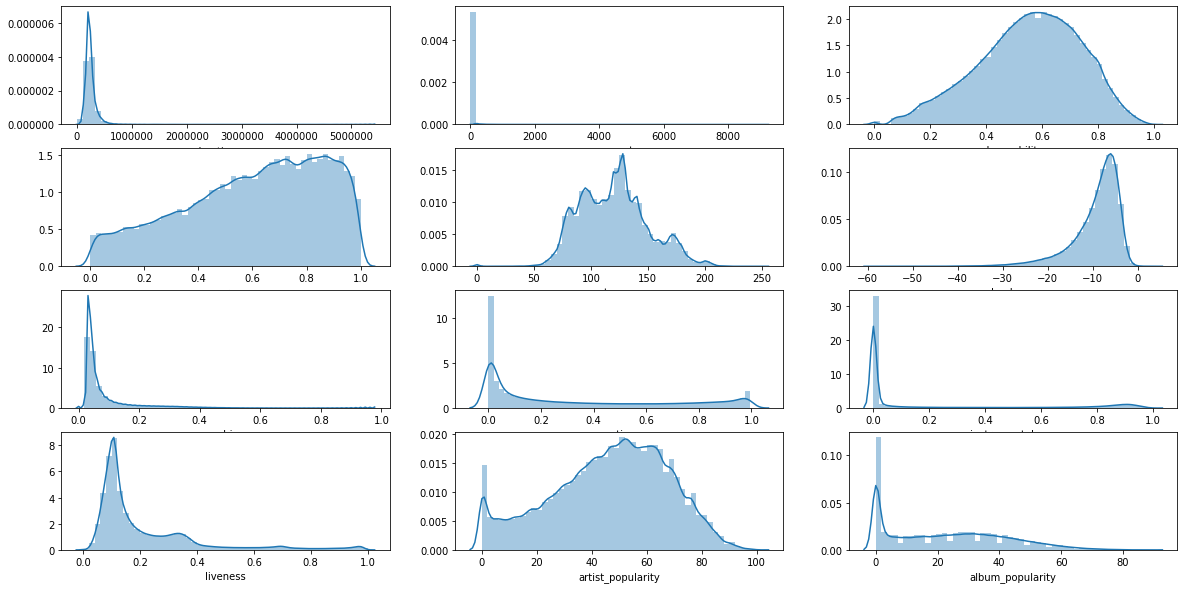

In [162]:
# Chart a number of histograms related to track features
start_time = time.time()
fig, ax = plt.subplots(4,3, figsize=(20,10))
columns = ["duration_ms", "count", "danceability", "energy", "tempo", "loudness",
                "speechiness", "acousticness", "instrumentalness", "liveness",
                "artist_popularity", "album_popularity"] #"valence", "key"
col_iter = iter(columns)
for row in range(4):
    for col in range(3):
        sns.distplot(songs[next(col_iter)], ax=ax[row,col])
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

## Pairwise associations

We next explore whether any features exhibit correlations between each other. We do this to get an early sense on if relationships exist that a model could learn or if any model we apply would struggle with randomness. The majority of features do appear to be randomly related, with data distributions materializing as complete squares on the pairplot graphs. There are some potential relationships that show promise, which we continued to explore in detail.

Time elapsed: 275.631 seconds


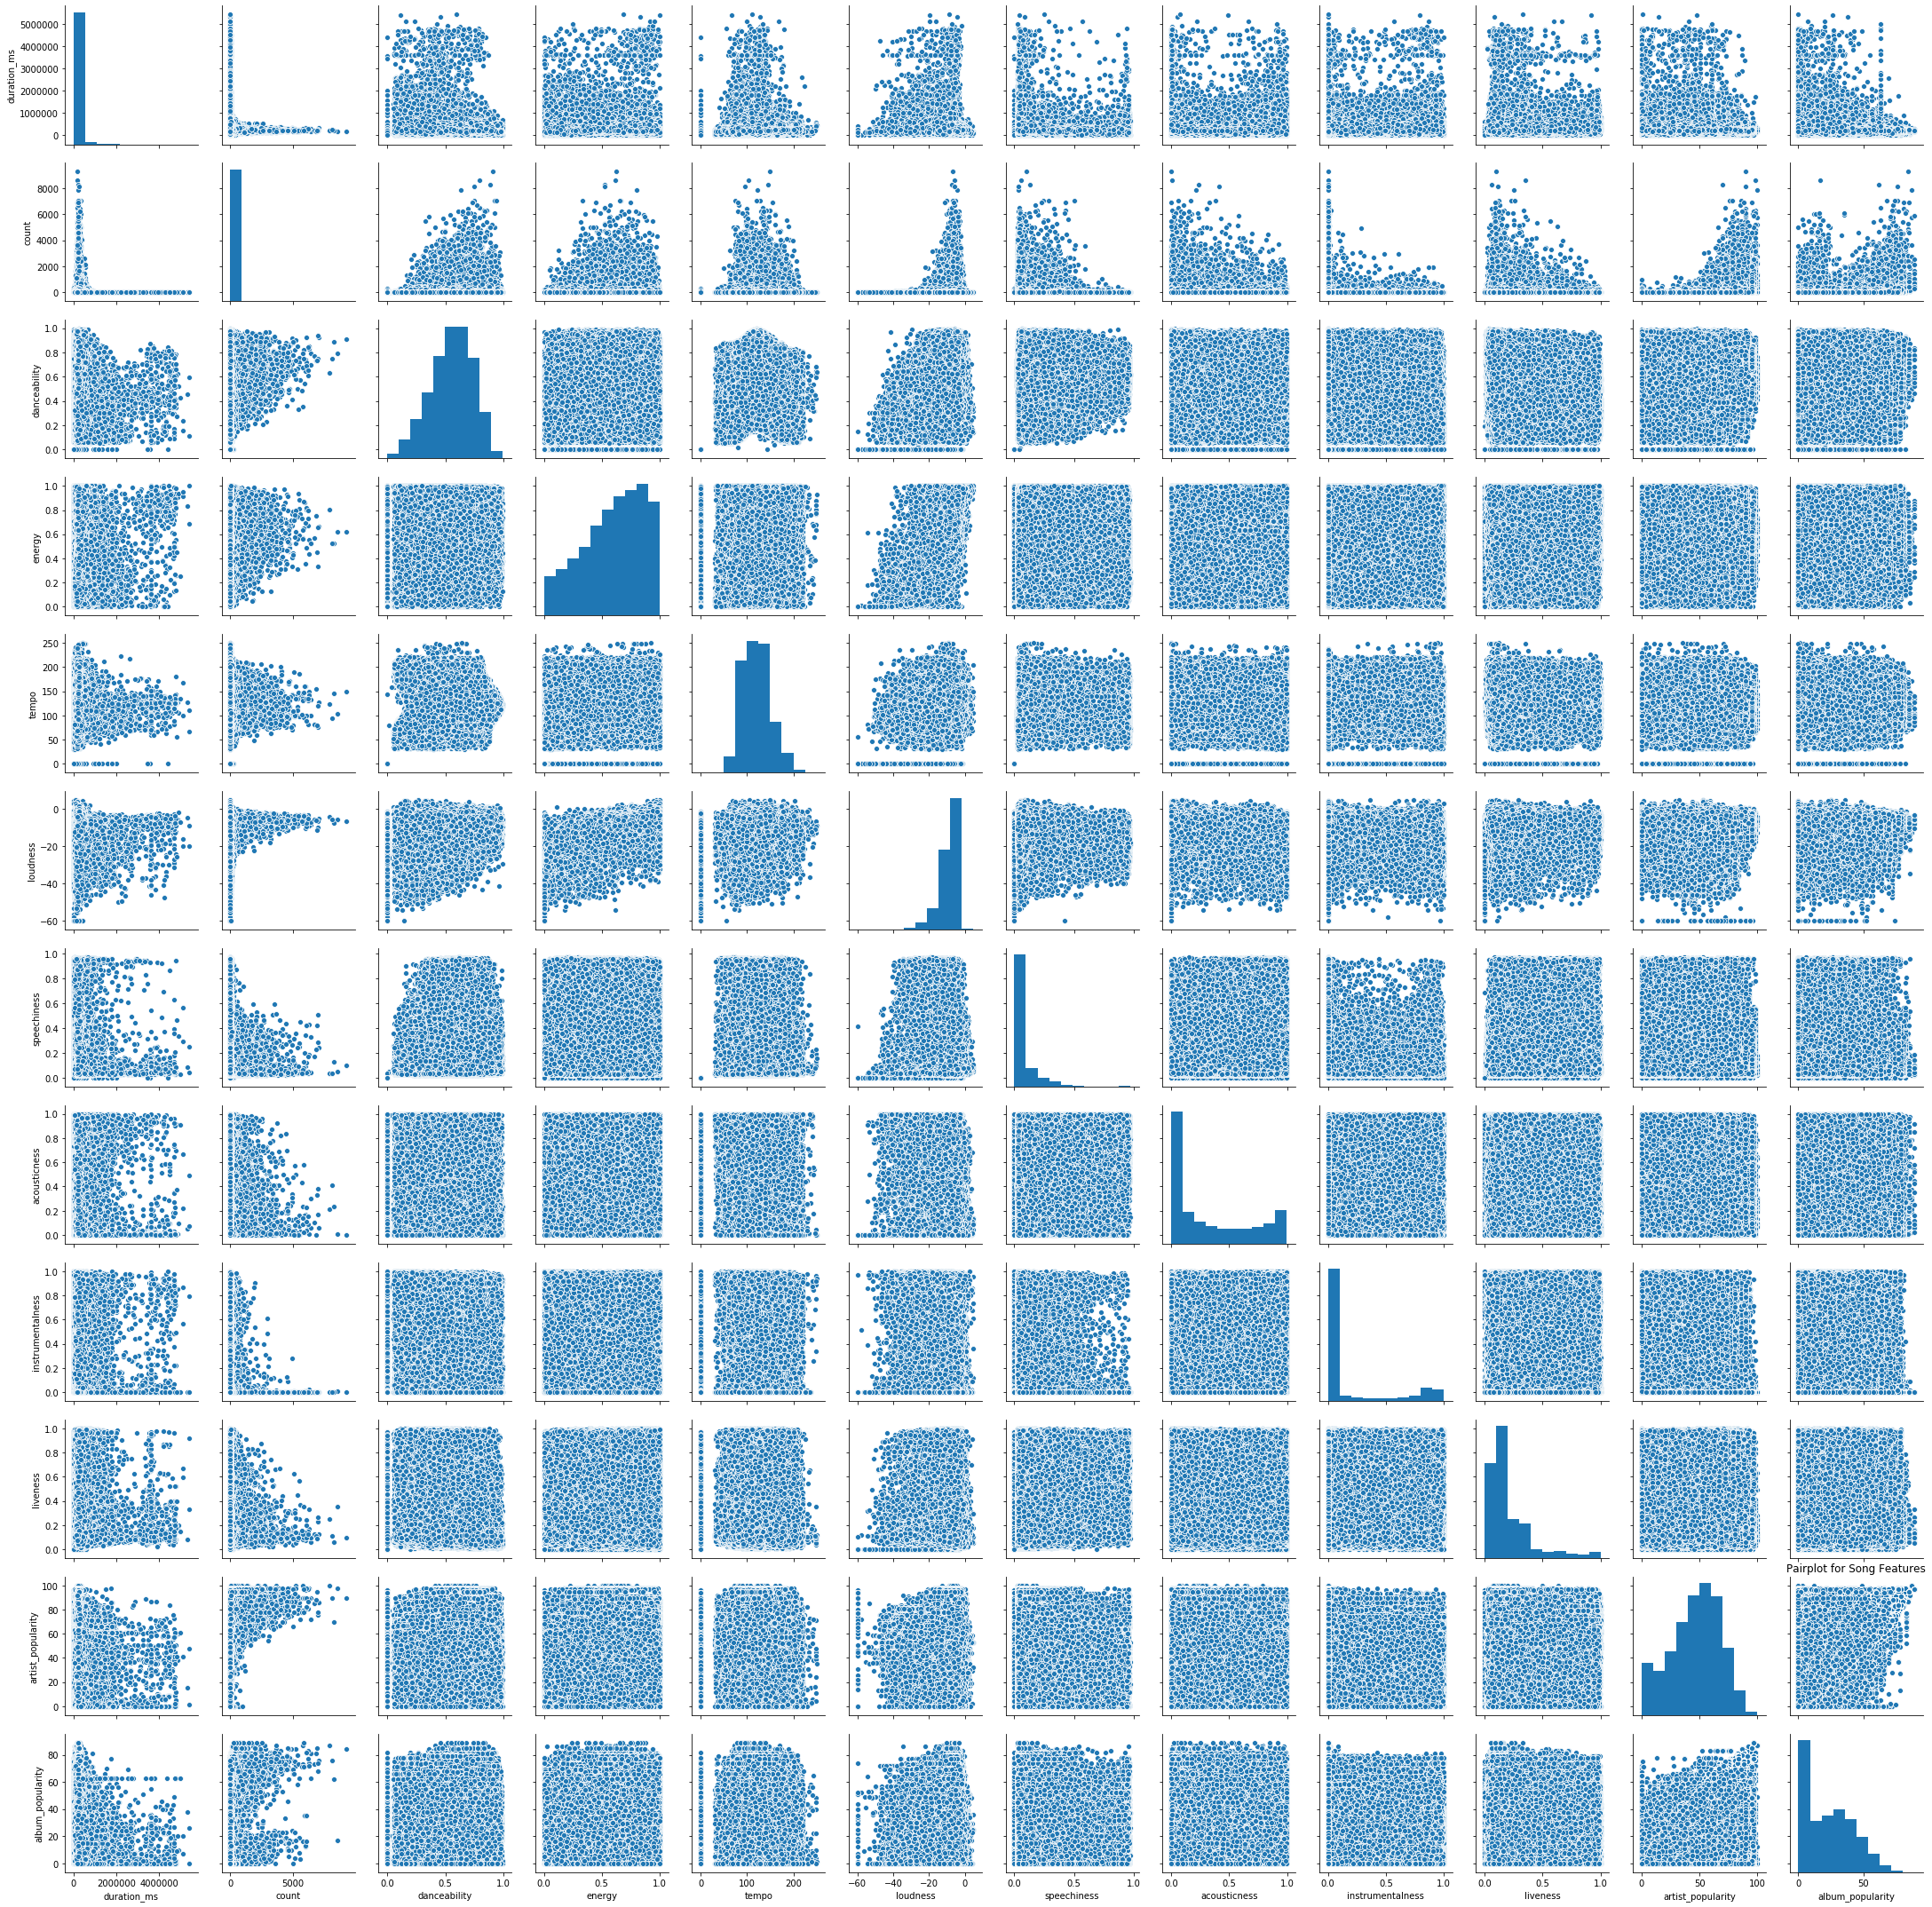

In [163]:
# Takes about 20 minutes so only uncomment and run intentionally
# Charts pairplot for all features against each other to identify colinear relationships
start_time = time.time()
to_plot = ["duration_ms", "count", "danceability", "energy", "tempo", "loudness",
                "speechiness", "acousticness", "instrumentalness", "liveness",
                "artist_popularity", "album_popularity"] #"valence", "key"
df_to_plot = songs.loc[:,to_plot]
# sns.pairplot(df_to_plot);
plt.title("Pairplot for Song Features")
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

`Energy` and `loudness` have the most visually linear relationship, where, as `energy` increases, so too does `loudness`. We have affectionately labeled this the "*Haley's Comet of Music*".

Time elapsed: 561.528 seconds


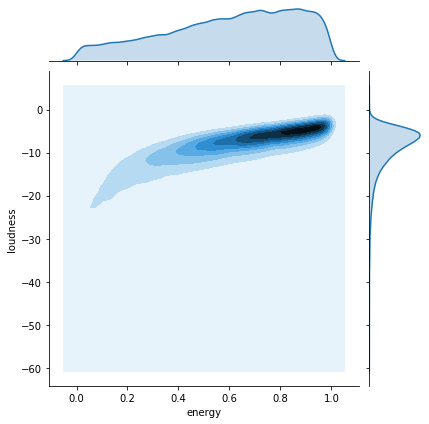

In [149]:
# Takes about 10 minutes so only uncomment and run intentionally
# Distribution plot of loudness vs energy
start_time = time.time()
# sns.jointplot(x="energy", y="loudness", data=songs, kind="kde");
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

`Tempo` and `danceability`, two features that have the most normal distributions, appear to mirror each other as well, with peaks at a `tempo` of 125 and a `danceability` range between 0.6 and 0.8.

Time elapsed: 817.11 seconds


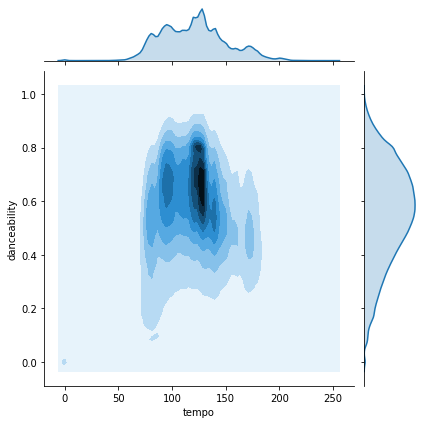

In [150]:
# Takes about 10 minutes so only uncomment and run intentionally
# Distribution plot of danceability vs tempo
start_time = time.time()
# sns.jointplot(x="tempo", y="danceability", data=songs, kind="kde");
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

Charting that same relationship between `tempo` and `danceability` on a scatterplot highlights that peak concentration even better. The "*Tempo Bump*" occurs at about 125 beats-per-minute (bpms) with a clear jump in `danceability`.

Time elapsed: 2.337 seconds


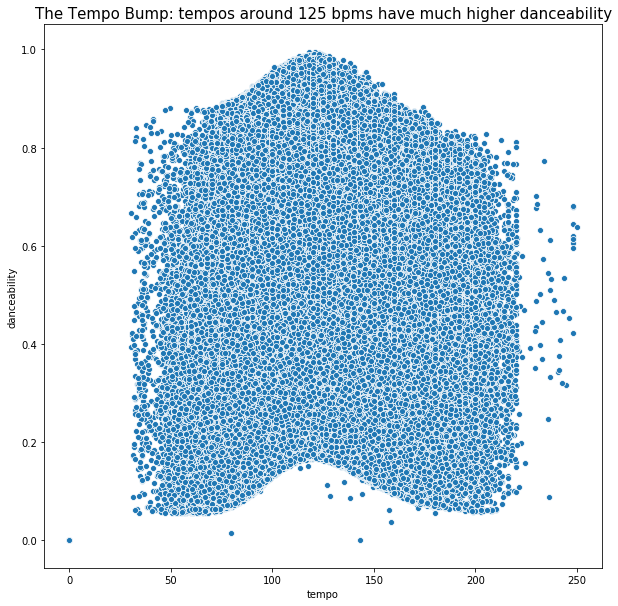

In [34]:
# Explores danceability by tempo
start_time = time.time()
plt.subplots(figsize=(10,10))
sns.scatterplot(x="tempo", y="danceability", data=songs); # The sweet spot of danceability
plt.title("The Tempo Bump: tempos around 125 bpms have much higher danceability", size=15)
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

## Are certain song features associated with playlist inclusion?

We next turned to whether song features had any relationship to playlist inclusion. Are certain features more predictive of the number of playlists they are likely to be included in?

We started with `danceability` and see the hint of a linear relationship, where as `danceability` increases so too does the number of playlists it will be included in. There remains a lot of song noise though, taken from the songs that we saw in our inclusion distributions earlier as just not being popular and added to only a few playlists.

Time elapsed: 1.953 seconds


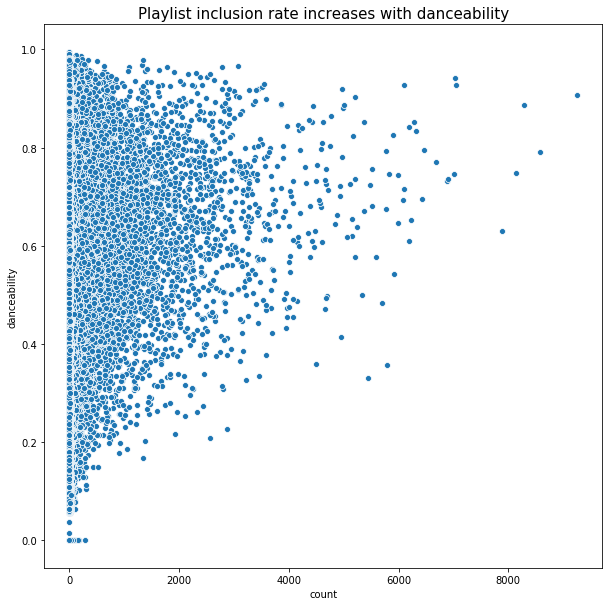

In [29]:
# Explores playlist inclusion by danceability
start_time = time.time()
plt.subplots(figsize=(10,10))
sns.scatterplot(x="count", y="danceability", data=songs)
plt.title("Playlist inclusion rate increases with danceability", size=15)
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

`Loudness` has a clear spike at about -8 but with fairly rigid hard limits above and below that. All songs softer than -20 are included in very few playlists. The same holds true for songs louder than ~0.

Time elapsed: 1.95 seconds


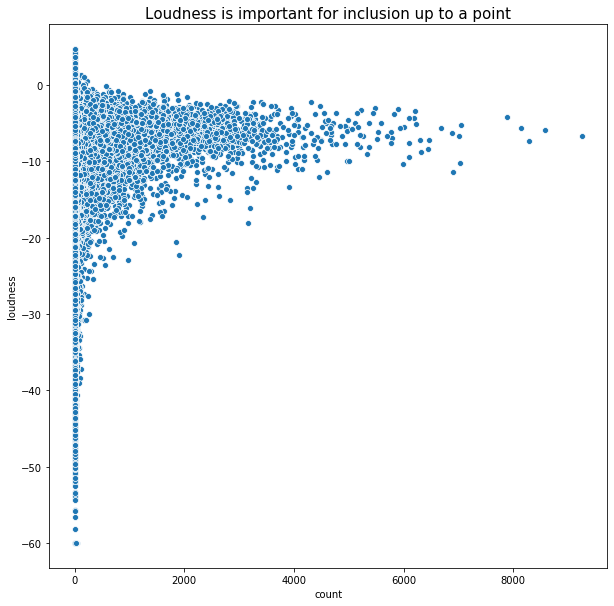

In [30]:
# Explores playlist inclusion by loudness
start_time = time.time()
plt.subplots(figsize=(10,10))
sns.scatterplot(x="count", y="loudness", data=songs);
plt.title("Loudness is important for inclusion up to a point", size=15)
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

`Energy` appears to have very little impact on playlist inclusion, with songs at every level of energy included at high amounts. Playlists vary across their desired theme, from slower classical music to upbeat electronic, so this mirrors our expectations.

Time elapsed: 1.973 seconds


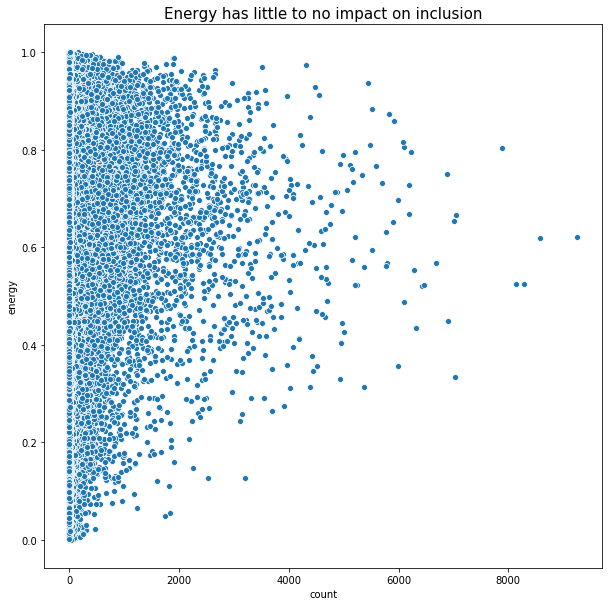

In [32]:
# Explores playlist inclusion by energy
start_time = time.time()
plt.subplots(figsize=(10,10))
sns.scatterplot(x="count", y="energy", data=songs);
plt.title("Energy has little to no impact on inclusion", size=15)
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

There exists the expected relationship between `artist_popularity` as calculated by Spotify and the number of playlists those songs are included in.

Time elapsed: 1.954 seconds


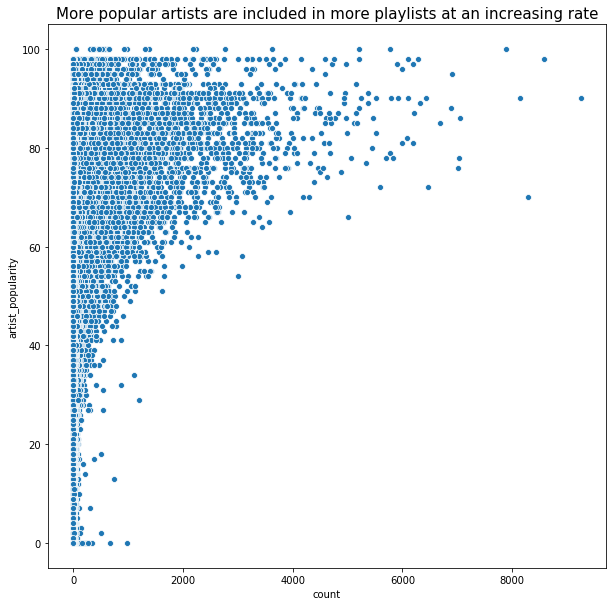

In [31]:
# Explores playlist inclusion by artist popularity
start_time = time.time()
plt.subplots(figsize=(10,10))
sns.scatterplot(x="count", y="artist_popularity", data=songs);
plt.title("More popular artists are included in more playlists at an increasing rate", size=15)
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

That expected linear relationship does not hold for `album_popularity` though. Instead, there is a clear delineation of playlist inclusion for both very popular albums and very unpopular albums. We posit that this is due to the phenomenon of one-hit wonders, whereby an album might be panned by critics and music fans overall but it was listened to and reviewed because it had one or two very popular songs. Those individual songs will be included in playlists, thanks to the flexibility of streaming services, even though the album overall remains unpopular. It is the middle range of albums, with no hit songs and an average rating, that are most at risk of not being included in playlists.

Time elapsed: 5.503 seconds


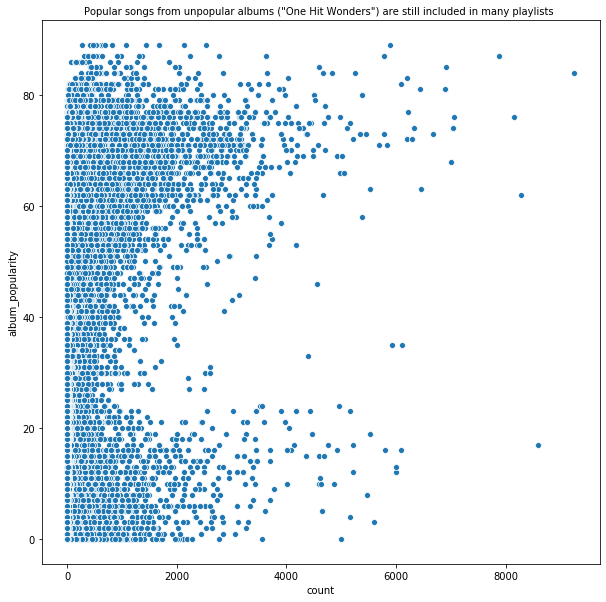

In [164]:
# Explores playlist inclusion by album popularity
start_time = time.time()
plt.subplots(figsize=(10,10))
sns.scatterplot(x="count", y="album_popularity", data=songs);
plt.title("Popular songs from unpopular albums (\"One Hit Wonders\") are still included in many playlists ", size=10)
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

Song duration (`duration_ms`), similar to loudness, has a very narrow band of lengths that users consider acceptable for playlist inclusion. This length is about 3.5 minutes, with songs longer than ~4 minutes appearing in an extremely low number of playlists.

Time elapsed: 1.935 seconds


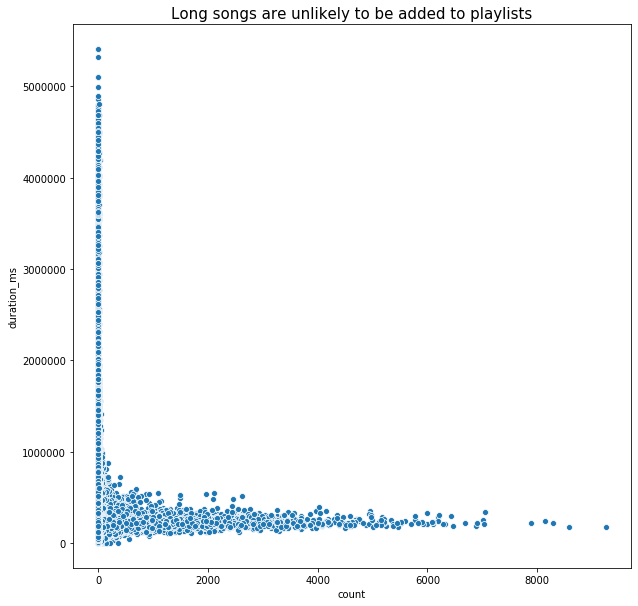

In [153]:
# Explores playlist inclusion by song duration
start_time = time.time()
plt.subplots(figsize=(10,10))
sns.scatterplot(x="count", y="duration_ms", data=songs);
# plt.axhline(y=350000, color="#1DB954", linestyle='-')
plt.title("Long songs are unlikely to be added to playlists", size=15)
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

The final continuous musical feature we explored was `tempo`. Our hypothesis was that there would exist several popular tempoes for different genres of songs, something we saw hinted at in our analysis of `energy`, so we expanded 'tempo' into a more detailed histogram. Our hypothesis proved true, with peaks occuring at 80, 100, 120, 128, 139 and 170, which we believe map to different genres of music.

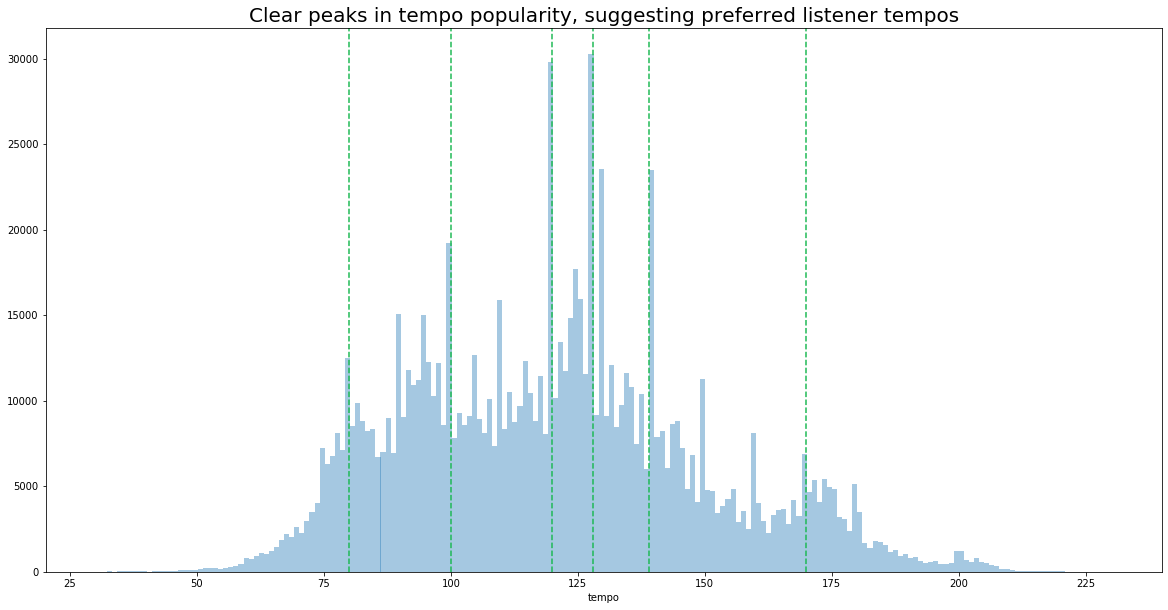

In [4]:
# Explores playlist inclusion by tempo excluding significant outliers
# Highlights peak tempo points of notable popularity
plt.subplots(figsize=(20,10))
sns.distplot(songs[(songs.tempo > 30)&(songs.tempo < 230)].tempo, kde=False, bins=200)
plt.axvline(x=80, color="#1DB954", ls="--")
plt.axvline(x=100, color="#1DB954", ls="--")
plt.axvline(x=120, color="#1DB954", ls="--")
plt.axvline(x=128, color="#1DB954", ls="--")
plt.axvline(x=139, color="#1DB954", ls="--")
plt.axvline(x=170, color="#1DB954", ls="--")
plt.title("Clear peaks in tempo popularity, suggesting preferred listener tempos", size=20);

## How have song features changed over time?

Moving on from exploring feature relationships, we next explored how these features have been changing over time for songs released in different years. We derived a new `release_year` column from the `album_release_date` column. We filter to all songs released between 1950 and 2017 to ensure sufficient data for our chart and show the distribution of release years currently in Spotify's library below.

In [15]:
# Derive new release_year column
start_time = time.time()
songs['release_year'] = songs.apply(lambda row: row['album_release_date'][0:4], axis=1)
print(songs['release_year'][0:5])
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

In [ ]:
# Filter to years with sufficient observations
century_songs = songs[(songs.release_year.astype(int) > 1950) & (songs.release_year.astype(int) < 2017)]

Time elapsed: 0.411 seconds


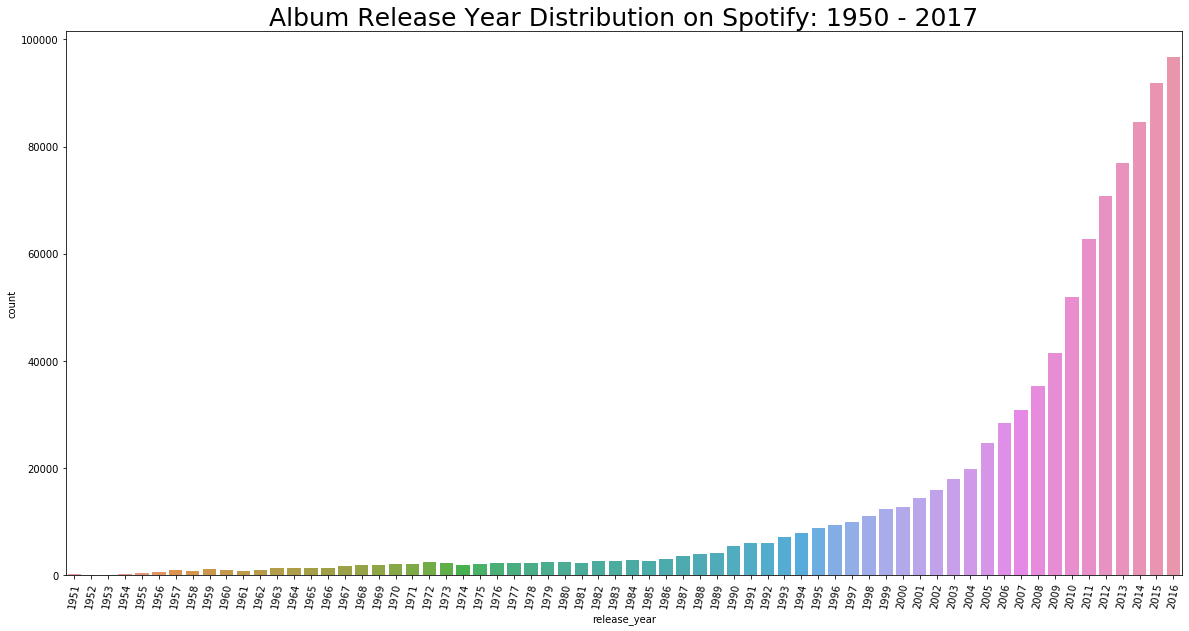

In [145]:
# Chart album_release_year distribution to understand when songs were made
start_time = time.time()
fig, ax = plt.subplots(figsize=(20,10))
sns.countplot(x="release_year", data=century_songs)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
ax.set_title("Album Release Year Distribution on Spotify: 1950 - 2017", size=25)
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

Varying features occur at different scales so we use `MinMaxScaler` from `sklearn` to scale them all between 0 and 1 and chart the changes on a single plot. The most dramatic cross over occurs with `acousticness` and `energy`, as the former declines severely starting in the 1950s and the latter rises steadily over time. The trend reverses itself temporarily during the 1980s but diverges again at a slower pace from 1990 to today. `Valence`, Spotify’s measure of positivity in a song, has also been declining at a slow but steady pace since about 1977.

In [ ]:
# Scale loudness and tempo to allow plotting on some chart as others
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
century_songs['loudness_scaled'] = sc.fit_transform(np.array(century_songs['loudness']).reshape(-1,1))
display(century_songs['loudness_scaled'][0:5])
century_songs['tempo_scaled'] = sc.fit_transform(np.array(century_songs['tempo']).reshape(-1,1))
display(century_songs['tempo_scaled'][0:5])

Time elapsed: 119.136 seconds


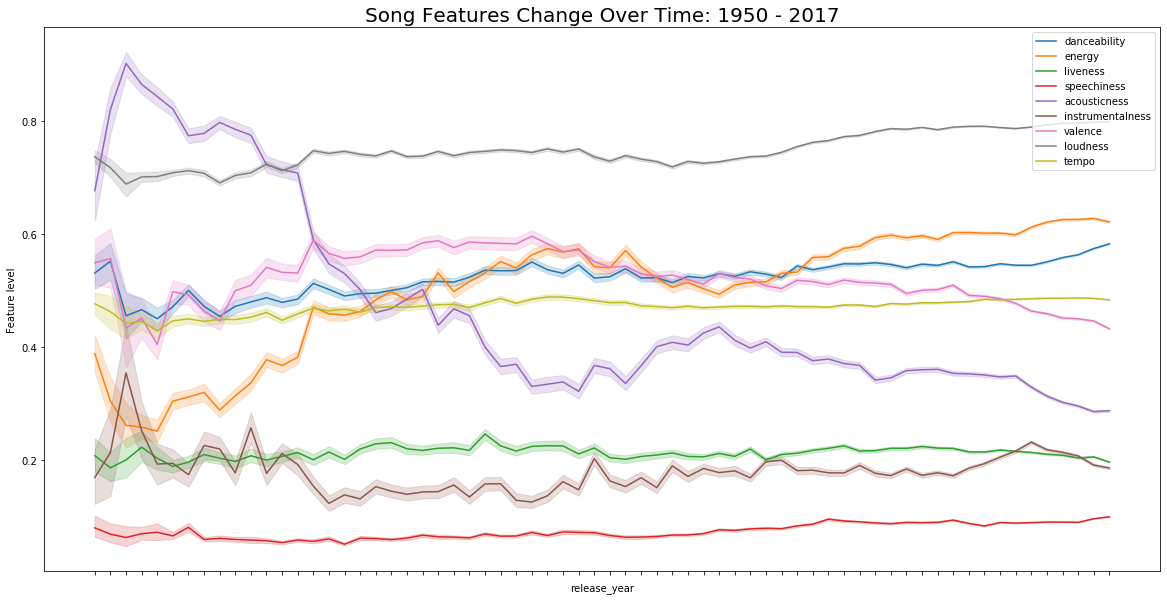

In [148]:
# Chart all track features over time
start_time = time.time()
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x="release_year", y="danceability", data=century_songs, label="danceability")
sns.lineplot(x="release_year", y="energy", data=century_songs, label="energy")
sns.lineplot(x="release_year", y="liveness", data=century_songs, label="liveness")
sns.lineplot(x="release_year", y="speechiness", data=century_songs, label="speechiness")
sns.lineplot(x="release_year", y="acousticness", data=century_songs, label="acousticness")
sns.lineplot(x="release_year", y="instrumentalness", data=century_songs, label="instrumentalness")
sns.lineplot(x="release_year", y="valence", data=century_songs, label="valence")
sns.lineplot(x="release_year", y="loudness_scaled", data=century_songs, label="loudness")
sns.lineplot(x="release_year", y="tempo_scaled", data=century_songs, label="tempo")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_title("Song Features Change Over Time: 1950 - 2017", size=20);
ax.set_ylabel("Feature level")
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

`Loudness` has been reaching record heights beginning in the 1990s. This may be associated with the spike in popularity that decade of electronic music due to the proliferation of cheap music production technology.

Time elapsed: 17.608 seconds


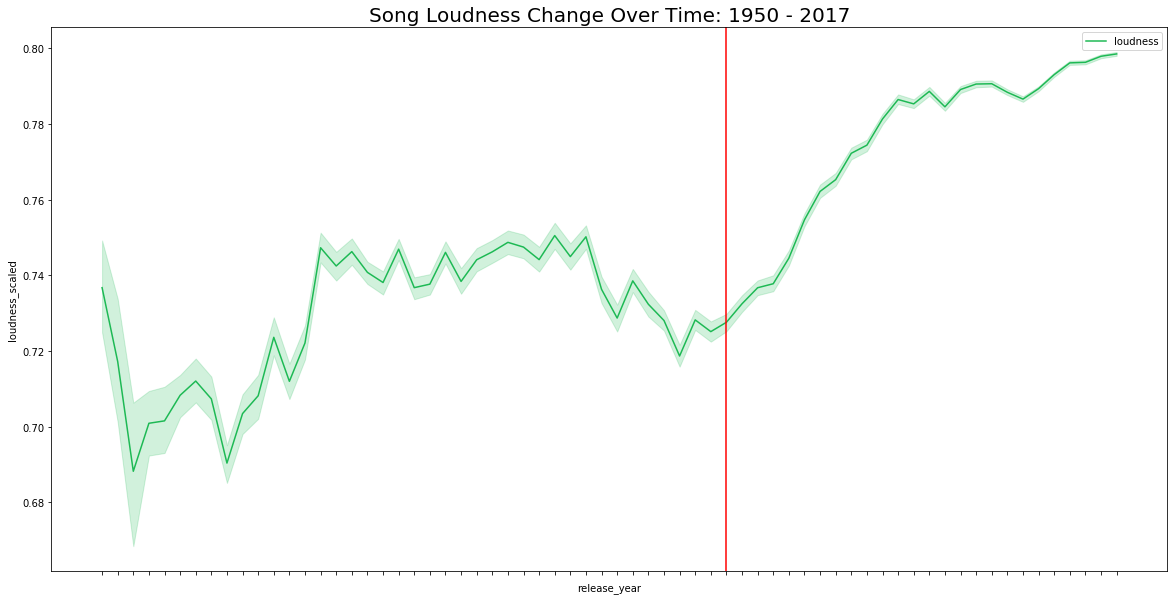

In [174]:
# Focus on loudness changes over time
start_time = time.time()
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x="release_year", y="loudness_scaled", data=century_songs, label="loudness", color="#1DB954")
plt.axvline(x=40, color="red")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
ax.set_title("Song Loudness Change Over Time: 1950 - 2017", size=20);
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

The most recent trend occurs with `danceability`, spiking to its highest ever levels starting in 2010.

Time elapsed: 17.19 seconds


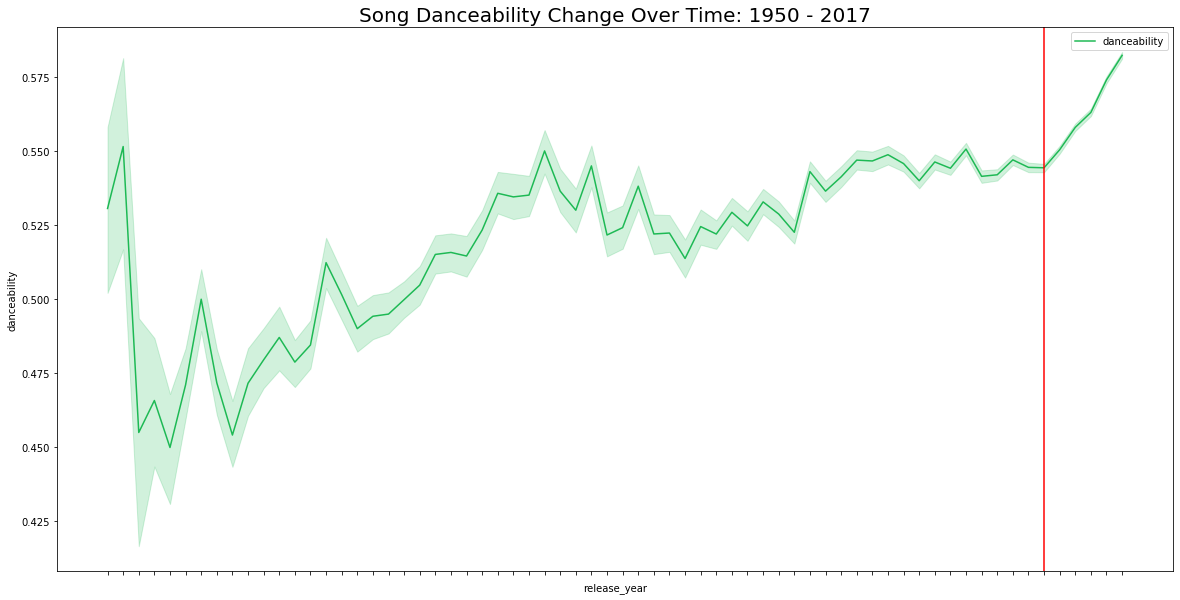

In [175]:
# Focus on danceability changes over time
start_time = time.time()
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(x="release_year", y="danceability", data=century_songs, label="danceability", color="#1DB954")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);
plt.axvline(x=60, color="red")
ax.set_title("Song Danceability Change Over Time: 1950 - 2017", size=20);
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

Lastly, we wanted to explore popular musical keys for songs as well as a sample of popular genres. If you filter to the Top 100 most included songs, there are clear preferences in song key at First Key (C♯/D♭) and Seventh Key (G, or sol). For playlists, *sleep* is actually a surprisingly popular genre, likely related to the number of extremely long songs. Unfortunately, beyond that, Spotify's structuring of genre makes analysis difficult. They include many specific genres for each album without specifying whether there is a primary genre. This means that there are potentially more popular genres than sleep, but in a simple histogram analysis, they will be reduced in frequency due to the varying nature of genre inclusions.

999950 100
Time elapsed: 0.528 seconds


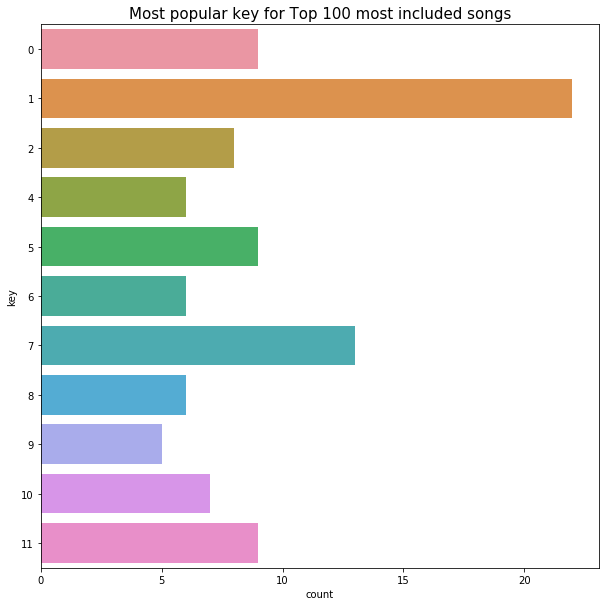

In [6]:
# Investigate musical keys of most popular songs
start_time = time.time()
preferred_artists = songs[songs['count'] > 4050]
print(len(songs), len(preferred_artists))
plt.subplots(figsize=(10,10))
sns.countplot(y="key", data=preferred_artists);
plt.title("Most popular key for Top 100 most included songs", size=15)
print('Time elapsed: {} seconds'.format(round(time.time()-start_time, 3)))

#### What did our exploration teach us?

There exist relationships among song features and between features and playlist inclusion that suggest a modeling approach would have something by which it could identify popular and similar songs. There are enough distinctions in musical features like `tempo` or `danceability` to suggest distinct types of songs. The majority of features appear unrelated to each other, with no visually discernible relationships and partially because of that, we wanted to apply techniques to reduce the number of dimensions used to the important ones.

# Leveraging Feature Importance through Dimensionality Reduction

In [145]:
import numpy as np
import pandas as pd

from scipy.sparse import csr_matrix, save_npz
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
assert tf.__version__ == '2.0.0'

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

Having seen that a few features appear important, we initiate dimensionality reduction in order to systematically confirm which ones those are. We start with some final data cleaning to confirm that our data is in the right state.

We start with the master table of song data. For the purposes of modelling, we need to convert it into a dataset of numerical predictors and do some feature engineering.

In [17]:
# Load master song table with added metadata
master = pd.read_pickle('../data/master200.pkl')
print('Dimensions:', master.shape)
display(master.head())

Dimensions: (999950, 25)


artist_name  \
song_id                                      
0        Sidney Bechet's Blue Note Jazzmen   
159583                       Sidney Bechet   
271702                       Sidney Bechet   
445190                       Sidney Bechet   
626275                       Sidney Bechet   

                                    artist_uri  \
song_id                                          
0        spotify:artist:2XouUSO0EAJ9gMMoHiXqMt   
159583   spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk   
271702   spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk   
445190   spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk   
626275   spotify:artist:1RsmXc1ZqW3WBs9iwxiSwk   

                                     track_name  \
song_id                                           
0                                Muskrat Ramble   
159583                             Blue Horizon   
271702   Blame It On The Blues - Alternate Take   
445190                               Summertime   
626275                       Dear Old Southland   

                                    album_uri  duration_ms     album_name  \
song_id                                                                     
0        spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       220293  Jazz Classics   
159583   spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       264933  Jazz Classics   
271702   spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       175893  Jazz Classics   
445190   spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       251906  Jazz Classics   
626275   spotify:album:04hQBJ7YSuNnZ0nbuXNYbY       243693  Jazz Classics   

         count                             track_uri  danceability  energy  \
song_id                                                                      
0            1  spotify:track:0002yNGLtYSYtc0X6ZnFvp         0.455   0.623   
159583       5  spotify:track:1EWPMNHfdVNJwBpG9BcxXB         0.327   0.372   
271702       1  spotify:track:26N4Y48EjprAtvlY6yWZTA         0.574   0.606   
445190      16  spotify:track:3RlJx8xwZEyToSuGrygilr         0.608   0.138   
626275       1  spotify:track:4qwAa1rOm8iaegHzoM1b31         0.400   0.320   

         ...  instrumentalness  liveness  valence    tempo  time_signature  \
song_id  ...                                                                 
0        ...             0.903    0.6340    0.951  182.345               4   
159583   ...             0.835    0.1530    0.380   66.036               4   
271702   ...             0.948    0.3490    0.965  101.361               4   
445190   ...             0.908    0.0853    0.318   83.124               4   
626275   ...             0.842    0.1950    0.613   86.186               4   

                                             artist_genres  artist_popularity  \
song_id                                                                         
0                                                       []                 18   
159583   ['bebop', 'big band', 'cool jazz', 'dixieland'...                 52   
271702   ['bebop', 'big band', 'cool jazz', 'dixieland'...                 52   
445190   ['bebop', 'big band', 'cool jazz', 'dixieland'...                 52   
626275   ['bebop', 'big band', 'cool jazz', 'dixieland'...                 52   

         album_genres  album_popularity  album_release_date  
song_id                                                      
0                  []                37          1993-01-01  
159583             []                37          1993-01-01  
271702             []                37          1993-01-01  
445190             []                37          1993-01-01  
626275             []                37          1993-01-01  

[5 rows x 25 columns]

There are a handful of missing values in the dataset. It's only a couple of observations, so we drop those as our models and analyses will fail with NAs present.

In [18]:
old = master.shape
master.dropna(axis = 0, inplace = True)
print('Removed', old[0] - master.shape[0], 'observations')

Removed 9 observations


We convert `album_release_year` to a continuous number of the release year. The day of month or month itself of the release date is likely much less important. We would ideally treat this as a categorical, but this would give a *lot* of levels that would not add significantly to our analysis.

In [20]:
master['album_release_year'] = np.array(
    [reldate[0:4] for reldate in master['album_release_date']], dtype = 'int')
master.drop(['album_release_date'], 1, inplace = True)

print('Artists missing genres: {}%'.format(
    round(100*np.sum(master.artist_genres == '[]')/master.shape[0], 2)))

Artists missing genres: 17.6%


There are a few predictors which are very sparse or contain no useful information and we elect to remove them from our data frame. These predictors are:
- `album_genres` is always empty. Either an old field in the API that is no longer used, or the data is not actually provided by Spotify. Either way, we can not use it.
- `track_uri` is the url to the track. This is unique to each song and cannot meaningfully be treated as a numerical predictor. It is saved in the original songs data frame for reference if we need it later.
- `album_uri` for the same reason.
- `artist_uri` for the same reason.
- `track_name` is textual and hard to do anything useful with. Future extensions could apply some textual data analysis or NLP.
- `artist_genres` is missing quite a few values, and varies greatly in terms of specificity and the number of genres assigned to an artist as we saw during data exploration. The inconsistency would make it challenging to create useful song-level features from it.

In [21]:
master.drop(labels = ['album_genres', 'track_uri', 'album_uri', 'artist_uri', 
                      'track_name', 'artist_genres'], axis = 1, inplace = True)

The remaining features of type `object` are `artist_name` and `album_name`. Again we might consider textual data analysis, but they are arguably best treated as categorical predictors, under the hypothesis that songs in the same album and/or by the same artist(s) likely fit well together.

There are however over 145,000 different artists and almost 300,000 albums. If we were to simply one-hot-encode these two categorical predictors that would yield 445,000 binary indicators, which is an extremely high number of dimensions.

In light of that, it is arguably redundant to keep both the album and artist names; if a song is in the same album, most of the time it will likely also be by the same artist. By that reasoning, `artist_name` may contain the salient information about and relatedness between songs. Hence, we will keep only the `artist_name` as a categorical, as we need to reduce the dimensionality of the data.

In [22]:
print('Unique artist names:', len(set(master.artist_name.values)))
print('Unique album names:', len(set(master.album_name.values)))

Unique artist names: 145623
Unique album names: 297432


In [23]:
master.drop('album_name', axis = 1, inplace = True)

# Load and prepare song-in-playlist indicators
Before we continue with preparing the songs data for modelling we will reduce dimensionality where appropriate by removing songs and playlists that are extremely rare, as we saw previously that there are very long tails of such cases.

We start by loading in the prepared list of lists that says which song IDs each playlist in the dataset consists of.

In [46]:
# Read list of lists: parent index is playlist ID, child index is song in that playlist
playlists = pd.read_pickle('../data/playlists_song_ids_200.pkl')

# Give each parent list a number, i.e. our internal playlist ID
play, song = zip(*enumerate(playlists))
print('Playlist 0 contains {} songs with IDs:\n{}'.format(len(song[0]), song[0]))

# Expand into pairs of playlist-song, i.e. 100-long playlist becomes 100 pairs
pairs = [[z[0], s] for z in zip(play, song) for s in z[1]]

# column is song ID, row is playlist ID
col, row = zip(*pairs)
assert len(row) == len(col)

Playlist 0 contains 13 songs with IDs:
[340039 125250 881533 653897  49614 356319 787744 603984 894661 461894
 776037 810569 855793]


In order to use this information of which songs are in which playlists for modelling, we wish to store it as a matrix of indicators. The row number is our internal song ID (from 0 to the number of songs), and the column number is our internal playlist ID (from 0 to the number of playlists). Each value, or cell in the matrix, is a binary indicator saying whether that song is in that playlist.

However, this would be a massive matrix of 1,000,000 rows and 200,000 columns. This is so big that the dense matrix itself would not fit in memory, let alone allow any calculations using it.

As such, we store this matrix as a *sparse* matrix. This is an object that doesn't store the full structure, but only records coordinate positions of non-zero values. In our case, this means only storing the indicators where a given song is in a given playlist. Using the appropriate packages we can then perform calculations on sparse matrices, greatly speeding up (or making it possible at all) computations.

In [53]:
# Create sparse matrix
mat = csr_matrix((np.ones(len(col), dtype = 'int'), (row, col)))
print('Indicators matrix dimensions:', mat.shape)
mat

Indicators matrix dimensions: (1003760, 200000)


<1003760x200000 sparse matrix of type '<class 'numpy.int64'>'
	with 13088889 stored elements in Compressed Sparse Row format>

When pulling song metadata some songs were removed, as the Spotify API returned no results. The songs-in-playlists indicators were created prior to that, so we drop the same songs from the sparse indicator matrix for consistency.

In [55]:
mat = mat[master.index.values, :]
assert mat.shape[0] == master.shape[0]
assert len(playlists[0]) == np.sum(mat[:, 0])

# Remove rare songs and short playlists

Per the long tails mentioned earlier, we drop songs that appear fewer than 5 times, and playlists that contain fewer than 10 songs. This reduces the dataset from about 1,000,000 songs by 200,000 playlists to just north of 200,000 songs by about 187,000 playlists.

In [73]:
# Indices of songs to keep
songs_keep_ind = np.argwhere(np.sum(mat, axis = 1) >= 5)[:,0]

# Reduce indicator matrix
mat_sub = mat[songs_keep_ind, :]
print('Sparsity of reduced indicator matrix: {}%'.format( 
      100*(1 - (np.sum(mat_sub)/(mat_sub.shape[0]*mat_sub.shape[1])))))

# Indices of playlists to keep
playlist_lengths = np.array(np.sum(mat_sub, axis = 0)).reshape((-1,))
mat_sub = mat_sub[:, playlist_lengths >= 10]
print('Reduced indicator matrix dimensions:', mat_sub.shape)

# Reduce master songs table
master_sub = master.iloc[songs_keep_ind, :]
print('Reduced songs table dimensions:', master_sub.shape)

# Verify that the reduced songs table and indicator matrix are consistent
assert len(songs_keep_ind) == mat_sub.shape[0] == master_sub.shape[0]

Sparsity of reduced indicator matrix: 99.97220166374167%
Reduced indicator matrix dimensions: (213675, 187313)
Reduced songs table dimensions: (213675, 18)


In [76]:
# Save reduced songs table to disk
master_sub.to_pickle('../data/final/master_reduced.pkl')

# Save reduced sparse indicator matrix to disk
save_npz('../data/final/indicators.npz', mat_sub)

# Categorical `artist_name` levels
Even after reducing the number of songs by almost 80% we still have over 34,000 different artists. One-hot-encoding this sole remaining categorical predictor would yield an extremely high-dimensional space, so we need to reduce it.

Considering the resulting matrix of binary indicators is based on a single categorical variable, every column is mutually exclusive with the rest. The covariance matrix will be nonsensical, hence methods like PCA are not appropriate; they may run and yield some result, but it would not be appropriate and would serve only to introduce additional noise. We considered a plethora of methods, from Multiple Correspondence Analysis (MCA) to Truncated Singular Value Decomposition (SVD), but all could be rejected on the above grounds, or were not implemented for sparse matrices and therefore were not computationally feasible.

In [135]:
print('Unique artist names:', len(set(master_sub.artist_name.values)))

Unique artist names: 34241


### The hashing trick
An alternative to exploding the categorical variable into tens of thousands of binary indicators by one-hot-encoding it is to work with the text data directly. To that end, we applied the *hashing trick*. For use with high-cardinality nominal categorical data, it simply applies a hash function to the different values of the sample matrix directly, in this case our vector of artist names. Each name is a different string and wil be assigned to a separate column index, *but* we can limit the number of columns (features) in the output matrix to limit specificity and reduce dimensionality – at the expense of hash collisions (error).

We certainly have a lot of hash collisions when we reduce over 30,000 unique values down to only 1,000 hash features. That being said, note that 1,000 hash features does not mean a cap of 1,000 unique values: each feature can be more than just $[0,1]$, and it is the combination of features that constitutes the hash.

The idea is not to use the hash directly, as we can't invert the transformation, but rather to limit the number of hash features to try to limit dimensionality with less then corresponding loss of signal (under the assumption that collisions are more likely between similar artist names), so that we can calculate distances between hashed artist names (when clustering).

In [139]:
hasher = FeatureHasher(n_features = 1000, input_type = 'string')
hashed_artists = hasher.fit_transform(master_sub['artist_name'].values)
print('Example of hashed artist name for first song (first 65 hash features):')
hashed_artists[0, 0:65].A

Example of hashed artist name for first song (first 65 hash features):


array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

# Using the indicator matrix
The reduced songs-in-playlist indicator matrix captures the co-occurrence of songs across playlists, which is presumably important information for which songs *belong* together in playlists. We wish to use this important information in our playlist generation, but there are two significant challenges:
- The indicator matrix is extremely high-dimensional as we have about 190,000 playlists remaining, and therefore as many columns in the indicator matrix. 
- It is extremely sparse, as most playlists have between 10 and 100 songs, but there are over 200,000 songs – and therefore nearly as many zeros in each playlist vector.

### Option A - Matrix decomposition
If we wish to perform calculations across the playlists, for instance to use as features in a clustering model or a supervised prediction model, we need to reduce dimensionality. Many methods will be prohibitively expensive as they expand the full matrix and perform matrix-wide operations, such as for calculating eigenvectors. For example PCA is not an alternative, as it runs out of memory. Furthermore, even if a method runs, the extreme sparsity will mean that the results of most are meaningless.

An example of an alternative method is **Truncated Singular Value Decomposition (SVD)**, a variant of SVD that performs linear dimensionality reduction by only computing the user-specified number of largest singular values. It is very similar to PCA, but is better suited to large sparse matrices as it performs computations directly on sample matrices rather than their covariance matrices, and therefore does not need to first densify the sparse matrix.

However, even after solving the computational challenge, we found that the indicator matrix sparsity is so great that matrix decomposition is not effective. Even with a very high number of components or remaining dimensions – which even defeats the purpose of dimensionality reduction – the explained variance is very low. It is in other words not practical to reduce dimensionality without losing too much information.

In [84]:
tsvd = TruncatedSVD(n_components = 1000, n_iter = 10, random_state = 42)

tsvd.fit(mat_sub)

print('Explained variance with {} components: {}%'.format(
    len(tsvd.explained_variance_ratio_), 
    round(100*np.cumsum(tsvd.explained_variance_ratio_)[-1], 3)))

Explained variance with 1000 components: 30.361%


### Option B: Vector distances

Rather than trying to boil the almost 200,000 dimensions down into a lower-dimensional sub-space, we keep the matrix as-is and use it directly to calculate distances between vectors. 

Each row in the matrix reflects a song in playlist space, hence the distance between two such vectors is a measure of how frequently those two songs occur in the same playlists. Similarly, each column is a playlist in songs space, so that more similar playlists – in terms of the songs they include – are reflected by a shorter distance between those two vectors.

The size and sparsity of the indicator matrix is again a challenge, but fortunately `scikit-learn` has a set of functions for calculating pairwise distances between vectors that is specifically engineered for sparse matrices. Two natural options are *Euclidean* distance (straight-line distance between vectors) and *Cosine* distance (angle between vectors).

For example, we can calculate the pairwise cosine distance between one song and all the others in playlist space – i.e. given a song, we find the closest songs based on co-occurrence across the playlists.

In [134]:
cos_dist = cosine_distances(mat_sub, mat_sub[0, :]).flatten()
print('Cosine distance between song #0 and closest 4 across playlists:\n', *np.sort(cos_dist)[0:5])
master_sub.iloc[np.argsort(cos_dist)[0:5], [0, 2, 3, 4, 15, 16, 17]]

Cosine distance between song #0 and closest 4 across playlists:
 0.0 0.7113248654051871 0.7226499018873854 0.7327387580875756 0.75


artist_name  count  danceability  energy  artist_popularity  \
song_id                                                                    
159583     Sidney Bechet      5         0.327   0.372                 52   
967165        Lee Morgan      5         0.658   0.521                 51   
644240      J.J. Johnson     16         0.466   0.395                 37   
265945   Ornette Coleman     14         0.467   0.316                 40   
141906     Sidney Bechet      5         0.597   0.498                 52   

         album_popularity  album_release_year  
song_id                                        
159583                 37                1993  
967165                 33                1965  
644240                 28                1989  
265945                 36                1959  
141906                 43                1994

Rather than using this information as features in our clustering or trying to reduce the dimensionality, we use such distance metrics to weight similarity of songs within clusters and to judge the quality of generated playlists compared to the existing playlists that are most similar in terms of the songs included.

# Scaling the numerical features
Prior to clustering, we must rescale the numerical features, as distance metrics used by clustering algorithms are highly sensitive to different distance units.

To that end we *normalise*, or apply *min-max* scaling, to the continuous numerical features and hashed artist names. Technically the hash should persists after min-max scaling, but even if not, we are more interested in differences between artist hashes than their scale.

Since this is an unsupervised problem and our aim is to generate playlists, there is no need for a train/test split, hence we normalise the dataset based on all the observations.

In [141]:
# Normalise continuous numerical features
master_sub_cont = master_sub.drop(['artist_name'], axis = 1)
scaled_cont = MinMaxScaler().fit_transform(master_sub_cont)

assert np.sum(np.amax(scaled_cont, axis = 0)) == master_sub_cont.shape[1]
assert np.sum(np.amin(scaled_cont, axis = 0)) == 0

# Normalise hashed artist names
scaled_artist = MinMaxScaler().fit_transform(hashed_artists.A)

# Autoencoder

Autoencoders are a type of neural network that aim to replicate the input by learning the most salient features of the input data while ignoring noise. Autoencoders achieve this by ingesting data through the input layer (which is the widest layer), "encoding" the data through the subsequently narrowing layers, and then "decoding" the data through subsequently widening layers. 

The narrowest layer in the middle contains only the most salient features of the data. The decoding layers attempt to recreate the input data using only these salient features. The output from the output layer is the network's representation of the input data.

We use autoencoders here as a technique to find clusters amongst our songs. Having trained the network to recreate the input data, we can "chop off" the network at its narrowest point. The middle layer has been trained to output the most salient features of the data. We use this output to define our clusters.

We have included links to our reference material in the Conclusion section of this paper.

---


We have two sets of numerical variables: the continuous numerical data, now min-max scaled, and the hashed artist names, also min-max scaled. Combining them with a uniformly weighted loss would mean the former get drowned out by the latter, as all mistakes are penalised equally but there are far more dimensions to the hashed artists. At the same time we expect the original continuous numerical variables to be more important, so this would be highly undesirable.

As such it seems more appropriate to fit separate autoencoders to the continuous variables and the hashed features.

### Autoencoder: continuous numerical data
The autencoder has an input layer with the same number of nodes as there are continuous numerical variables in the dataset – as usual. It has two wide layers that process the raw inputs using ReLU activation, followed by a final encoding layer that compresses it down into 5 dimensions. The encoding layer, or bottleneck, has a sigmoid activation in order to constrain the range of values in the lower-dimensional space to the range $(0,1)$.

The number of dimensions in the compressed space is a trade-off between allowing the network sufficient representational power to accurately reconstruct the raw inputs, while forcing it to pick out the salient features and relationships in order to generalise. It therefore also has a regularising effect, such that there is little need for extra regularisation in the form of L1 or L2 kernel penalisation, dropout, and/or batch normalisation. The bottleneck itself imposes significant bias on the network topology.

Considering the large number of observations, a $10%$ validation set is more than enough for a reliable estimate of out-of-sample performance. It is worth noting that this validation set was part of the set on which the normalisation scaler was fitted, so there is potentially some information bleed here, but the size of the dataset and homogeneity of predictor values makes this negligible.

In [167]:
inputs = Input(shape = (scaled_cont.shape[1],))

encoder = Dense(500, activation = 'relu')(inputs)
encoder = Dense(500, activation = 'relu')(encoder)

# Compress into much lower-dimensional space
# Force lower-dimensional representation values between [0, 1] (like minmax)
encoder = Dense(5, activation = 'sigmoid')(encoder)

# Lossy decompression
decoder = Dense(500, activation = 'relu')(encoder)
decoder = Dense(500, activation = 'relu')(decoder)
decoder = Dense(scaled_cont.shape[1])(decoder)

# Autoencoder maps raw input to lossy reconstruction
autoencoder = Model(inputs, decoder)

autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 17)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 500)               9000      
_________________________________________________________________
dense_29 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 2505      
_________________________________________________________________
dense_31 (Dense)             (None, 500)               3000      
_________________________________________________________________
dense_32 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_33 (Dense)             (None, 17)                8517

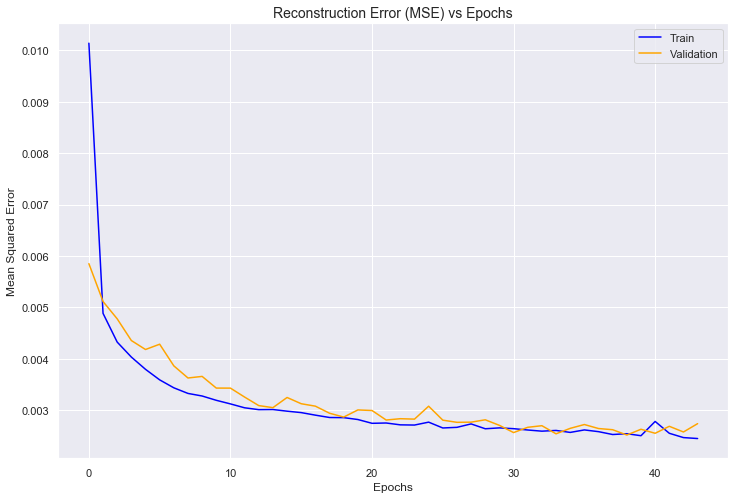

In [43]:
autoencoder.compile(optimizer = 'adam', loss = 'mse')

reconstruct_cont = autoencoder.fit(
    scaled_cont, # Data is input,
    scaled_cont, # and output: try to reconstruct accurately
    epochs = 100,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)],
    verbose = 0
)

plt.figure(figsize = (12, 8))
plt.plot(reconstruct_cont.history['loss'], c = 'blue', label = 'Train')
plt.plot(reconstruct_cont.history['val_loss'], c = 'orange', label = 'Validation')
plt.title('Reconstruction Error (MSE) vs Epochs', fontsize = 14)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend()

Training of the autoencoder is stopped after $44$ epochs, as validation loss is no longer improving. After fitting is complete, we extract the encoder, i.e. the first half of the neural network up to and including the narrow layer bottleneck, which maps raw inputs to their compressed representation. 

Using that sub-network to run predict on the raw minmax-scaled continuous data, we get the compressed representation. The resulting matrix with five dimensions is saved to disk, so that we can cluster on it.

In [45]:
# Extract the encoder: maps raw inputs to their compressed representation
encoder = Model(inputs, encoder)

# Get compressed dataset of continuous numerical variables
auto = encoder.predict(scaled_cont)

# Save to disk
np.save('../data/final/encoded_cont_5wide', auto)

# Print dimensions for verification
auto.shape

(213675, 5)

### Autoencoder: hashed artists
For artist names a validation split of $10\%$ may seem low. However, we have 30,000 unique artist names across 200,000 observations, captured by 1,000 hashed features, so if the validation set is too large it will contain many observations that are the only observations of some artist hashes. This would reduce the overall effectiveness of the autoencoder at capturing as much of the salient information as possible in its compressed space. As such, we still use $10\%$ of the observations for validation, which still gives 20,000 observations and should be plenty to representatively evaluate out-of-sample performance.

After some experimentation the encoding layer now outputs $20$ dimensions rather than $5$, in order to strike a better balance between compression and accuracy in this much higher-dimensional input space (1,000 hashed artist names versus $17$ continuous variables).

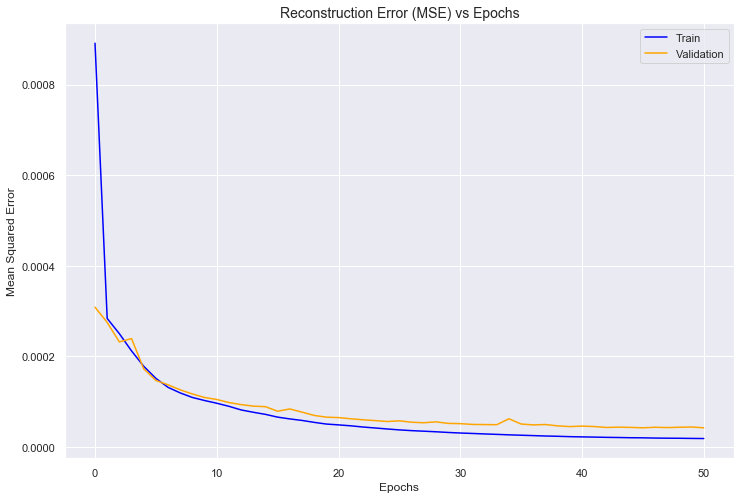

In [55]:
inputs = Input(shape = (scaled_artist.shape[1],))

encoder = Dense(500, activation = 'relu')(inputs)
encoder = Dense(500, activation = 'relu')(encoder)
encoder = Dense(20, activation = 'sigmoid')(encoder)
decoder = Dense(500, activation = 'relu')(encoder)
decoder = Dense(500, activation = 'relu')(decoder)
decoder = Dense(scaled_artist.shape[1])(decoder)

autoencoder = Model(inputs, decoder)

autoencoder.compile(optimizer = 'adam', loss = 'mse')

reconstruct_artist = autoencoder.fit(
    scaled_artist,
    scaled_artist,
    epochs = 100,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)],
    verbose = 0
)

plt.figure(figsize = (12, 8))
plt.plot(reconstruct_artist.history['loss'], c = 'blue', label = 'Train')
plt.plot(reconstruct_artist.history['val_loss'], c = 'orange', label = 'Validation')
plt.title('Reconstruction Error (MSE) vs Epochs', fontsize = 14)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.legend()

As before early stopping is triggered, this time after 50 epochs. The loss is *very* low, but this is arguably more because there is a mean of one value $1$ across 1,000 dimensions per observation. The network has no context with which to encode artist hashes into a lower-dimensional space, and is working with extremely sparse data, so this is a virtually impossible task. Spot checks revealed that it was generally performing poorly at the task of reconstructing the normalised hashes, despite what the plot and training history would suggest. Hence, this autoencoder and its constituent encoder was discarded for the rest of the project.

## Resulting dataframe

We applied several different methods of dimensionality reduction and ultimately produced a dataframe of reduced continuous song features. While we examined and tried to include the categoricals, their performance at reconstructing the normalised hashes was poor and we felt they would add little to the next step in our modeling. With this reduced dataframe of five criticla musical features, we moved to explore how we could group songs using this information.

# Identifying Clusters of Songs

Our belief in generating playlists is that each playlist should have a theme, which we thought would be best represented by clustering songs. With these clusters, we could assume that songs are similar along some dimensions identified by the unsupervised machine learning algorithm and would go well together on a single playlist. We explored several methods of clustering to find groups of songs that belong together based on their characteristics such as tempo, valence, etc.

In [1]:
# Import packages necessary for clustering
import numpy as np
import pandas as pd
import time
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join

import scipy.sparse

sns.set()
%matplotlib inline

In [4]:
# Load master song table with added metadata
master = pd.read_pickle('../data/master200.pkl')
master_reduced = pd.read_pickle('../data/master_reduced.pkl')

song_ids = master_reduced.index.values
cont_feats = list(master_reduced.drop(['artist_name', 'album_name'], 1).columns)

encoded_cont = np.load('../data/encoded_cont_5wide.npy', allow_pickle = True)

indicators = scipy.sparse.load_npz('../data/indicators.npz')

# t-SNE Visual Representation

We used the technique t-Distributed Stochastic Neighbor Embedding (t-SNE) to visualize our high-dimension data in the 2-D space. We show below the t-SNE representations of the data output from the autoencoder we trained for clustering.

t-SNE maps each datapoint in the higher dimension input dataset to a lower dimension space (typically 2-D or 3-D) for the purposes of visualization. The mapping is created in a way such that nearby points in the lower dimension space correspond to "similar" datapoints in the original space and distant points correspond to "dissimilar" datapoints. The lower dimension representation can then be consumed similar to other standard visualizations such as scatterplots.

t-SNE applies dimension reductionality probabilistically, in comparison to Principal Component Analysis (PCA) which applies a mathematical function to calculate the direction of minimum error. t-SNE is a computationally intensive technique because it looks at data distributions and attempts to calculate similar representations with fewer dimensions for each dimension. 

We use t-SNE only for visualization here. The downside is that interpretability becomes slightly harder as t-SNE will represent a reduced 2-D cluster that is different than the *N*-Dimensions that our clustering algorithms are actually using to identify song types.

In [31]:
# Data already shuffled, so we can pull a random subset of train data for visualisation
np.random.seed(42)
tsne_ind = np.random.choice(np.arange(encoded_cont.shape[0]), 10000)

In [ ]:
from sklearn.manifold import TSNE
time_start = time.time()

tsne = TSNE(n_components = 2, verbose = 0, perplexity = 40, n_iter = 300)
#tsne = TSNE(n_components = 2, verbose = 0, n_iter = 300)

tsne_results = tsne.fit_transform(encoded_cont[tsne_ind])
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components = 2, verbose = 0, perplexity = 50, n_iter = 300)
#tsne = TSNE(n_components = 2, verbose = 0, n_iter = 300)
tsne_results = tsne.fit_transform(encoded_cont)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

What does data look like in a 2-D t-SNE space? We plotted a random selection of four playlists (colored dots) into the t-SNE space to demonstrate how the data behaves through this representation. If we assume that playlists are already thematically grouped and includes similar songs, our resulting t-SNE chart is a big surprise. It appears that at least at two dimensions, a single playlist is nearly randomly dispersed across the t-SNE space. We'll need to apply better multi-dimensional clustering to improve resulting plots.

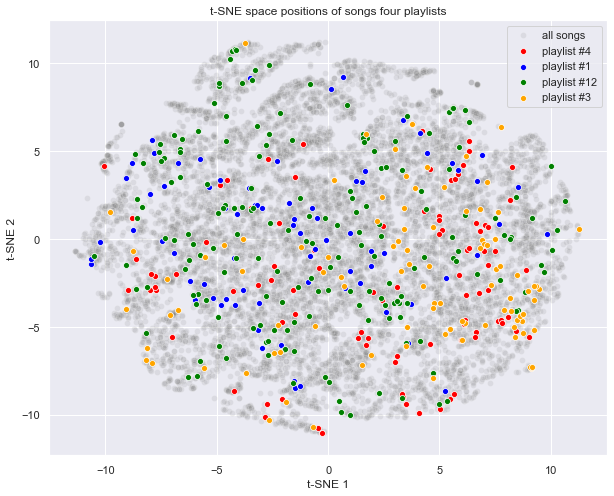

In [175]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[tsne_ind, 0], 
    y = tsne_results[tsne_ind, 1],
    #hue = k_labels[tsne_ind],
    #palette = sns.color_palette("hls", len(np.unique(k_labels[tsne_ind]))),
    legend = "full",
    color = 'grey',
    alpha = 0.15,
    label = 'all songs'
)

psi = list(np.argwhere(indicators[:, 4].A.reshape((-1,)) == 1).reshape((-1,)))
ax = sns.scatterplot(
    x = tsne_results[psi, 0], 
    y = tsne_results[psi, 1],
    color = 'red',
    alpha = 1.0,
    label = 'playlist #4'
)

psi = list(np.argwhere(indicators[:, 1].A.reshape((-1,)) == 1).reshape((-1,)))
ax = sns.scatterplot(
    x = tsne_results[psi, 0], 
    y = tsne_results[psi, 1],
    color = 'blue',
    alpha = 1.0,
    label = 'playlist #1'
)

psi = list(np.argwhere(indicators[:, 12].A.reshape((-1,)) == 1).reshape((-1,)))
ax = sns.scatterplot(
    x = tsne_results[psi, 0], 
    y = tsne_results[psi, 1],
    color = 'green',
    alpha = 1.0,
    label = 'playlist #12'
)

psi = list(np.argwhere(indicators[:, 3].A.reshape((-1,)) == 1).reshape((-1,)))
ax = sns.scatterplot(
    x = tsne_results[psi, 0], 
    y = tsne_results[psi, 1],
    color = 'orange',
    alpha = 1.0,
    label = 'playlist #3'
)

ax.legend()

ax.set(title = 't-SNE space positions of songs four playlists',
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')

plt.savefig('playlist_songs_in_space.pdf'.format(time.time()))

# K-Means Clustering

K-Means was our initial clustering model, serving as our baseline playlist generation algorithm and as a core input into our final playlist algorithm. Our baseline playlist generation algorithm consisted of basic K-Means clustering, whereby we clustered songs by the properties available after our initial cleaning and transformation process. A user could then provide a handful of songs to cold start the playlist, after which we'd select future songs from the same cluster as the provided songs until our playlist was full.

K-Means works by identifying the closest cluster center (called the centroid) for every data point and labels that data point as a member of that cluster. It optimizes the identified clusters by minimizing the cluster's sum of squares (Euclidean distance) around the centroid so that each cluster will be as narrow and focused as possible. Since K-Means uses the sum of squares to identify clusters, we need to be careful with higher dimension data since different scales for each variable can lead to the distances to blow up.

K-Means requires the manual specification of a target number of clusters, which we selected to be 15 for our final model. This presented an initial challenge as we became familiar with our data, not knowing how many clusters was a reasonable target, but through parameter tuning we were able to choose a selection that represented sufficient separation. 

For our final model, we take the 5 variables resulting from the autoencoder dimension reduction technique to identify 15 clusters using K-Means.

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_jobs = -1, n_clusters = 15, n_init = 20, 
                max_iter = 300, random_state = 42, verbose = 0)

kmeans.fit(encoded_cont)

cluster_centers = kmeans.cluster_centers_
k_labels = kmeans.labels_

We list here the number of songs belonging to each cluster to provide a numerical assessment of size in addition to the visual graph.

In [11]:
# Sizes of fit clusters (num songs in each)
clust, count = np.unique(k_labels, return_counts = True)
for cl, co in zip(clust, count):
    print(cl, ':', co)

0 : 17434
1 : 7447
2 : 16620
3 : 10878
4 : 17170
5 : 10155
6 : 12500
7 : 20787
8 : 12098
9 : 11318
10 : 21551
11 : 5942
12 : 20485
13 : 8673
14 : 20617


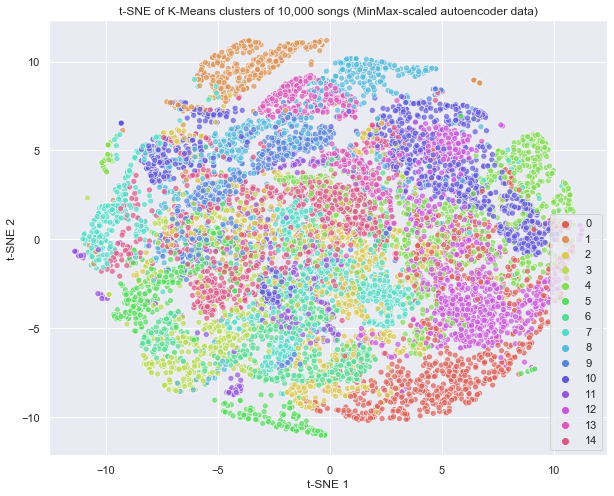

In [155]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[tsne_ind, 0], 
    y = tsne_results[tsne_ind, 1],
    hue = k_labels[tsne_ind],
    palette = sns.color_palette("hls", len(np.unique(k_labels[tsne_ind]))),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of K-Means clusters of 10,000 songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')

plt.savefig('kmeans_subset.pdf')

## K-Means Assessment

K-Means provides us with the provided number of clusters but few of these appear to maintain any sort of distance separation from other clusters, suggesting that they may be more intertwined than we'd like. For playlist generation, we can leverage K-Means and the assumption that even if these songs are extremely distinct, they are still the *most* similar songs. This assumption works for song selection because even if most songs are similar across genres, a pop song will still be more similar to another pop song than it will be to a death metal song.

# HDBSCAN Clustering

HDBSCAN is a library of software tools that implements a clustering algorithm developed by [Campello, Moulavi, and Sander](http://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14). It is a powerful step above K-Means in that it does not require you to specify the number of clusters, but instead analyzes density distribution, assumes a certain level of noise, and returns only clusters of data that reach a certain threshold of density. Given the diversity of song styles, our hypothesis was that there would be a large number of "noise" songs, songs that don't fit into an identifiable category and that are best ignored when generating a playlist with a desired theme. What should remain after HDBSCAN are clusters of songs that are similar enough to have an enjoyable thematic experience in our new playlist.

To better understand the HDBSCAN algorithm, let's explore its process step-by-step. First, HDBSCAN estimates density using distance to *k*th nearest neighbors for each point, referred to in the literature as *core distance*. A second distance metric, referred to as *mutual reachability distance*, is calculated between every pair of points using *Core distance* as an input, which serves to spread sparse points farther away while leaving denser points relatively untouched. HDBSCAN considers the data of distance metrics as a weighted graph with the data point as a vertex and an edge weighted equally to the mutual reachability distance. The algorithm then takes a threshold value, starting high and steadily lowering, that begins to drop edges with weights (i.e. distances) above that threshold. As the threshold continues to lower, the algorithm continues to drop edges into the "noise" categorization. HDBSCAN defines a stopping mechanism using a "minimum spanning tree", which doubles as a efficiency gain technique. From this tree, it produces a hierarchy of connected components by sorting trees by distance and then condenses this clustered tree further by treating cluster splits as "losing points" from a primary cluster instead of as two new clusters being created. This allows HDBSCAN to maintain its high absolute bar for what a cluster is. If a "new cluster" has fewer points than the minimum required cluster size, it is considered "lost points to noise" instead of a new cluster. Lastly, it extracts remaining clusters and returns them for labeling. HDBSCAN for our data returns 18 clusters.

In [16]:
import hdbscan as h

hdb = h.HDBSCAN(min_cluster_size = 100, cluster_selection_method = 'leaf')

hdb.fit(encoded_cont)

print("Number of clusters:", np.max(hdb.labels_)+1)

Number of clusters: 18


### HDBSCAN Assessment

In contrast to the generated K-Means clusters, we immediately see that HDBSCAN produces very different results thanks to its inclusion of the concept of noise. Any song marked as belonging to cluster *-1* is classified as noise and the vast majority of songs are classified into this cluster by HDBSCAN.

The library does identify five major song clusters (those that are colored pink, purple, blue, teal and yellow). This suggests that there are certain types of songs that are highly similar in their melody, tempo or other song attributes but that on the whole, there is not enough density to group most songs into a confident cluster. This presents challenges for our playlist generation algorithm, as our hypothesis rests on songs being similar enough to allow like selection.

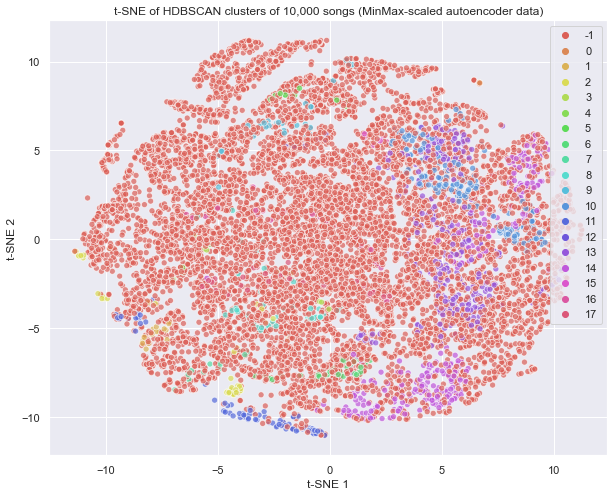

In [156]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[tsne_ind, 0], 
    y = tsne_results[tsne_ind, 1],
    hue = hdb.labels_[tsne_ind],
    palette = sns.color_palette("hls", len(np.unique(hdb.labels_[tsne_ind]))),
    legend = "full",
    alpha = 0.7
)

ax.set(title = 't-SNE of HDBSCAN clusters of 10,000 songs (MinMax-scaled autoencoder data)', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')
plt.savefig('hdbscan_subset.pdf')

# Clustering Conclusion

After trying to cluster songs via K-Means and HDBSCAN, we're left with the feeling that based on the song attributes we have collected, it is challenging to identify distinct patterns of song in an absolute sense. 

HDBSCAN was able to identify a handle of small but dense clusters that we can have confidence are similar to each other but the majority of songs across genres are similar enough as to be undifferentiable. For playlist generation, we can still rely on relative differentiation to identify the next song selection.

To assess whether our methods were effective, we chose to plot a single playlist after clustering. We considered HDBSCAN first but due to the high proportion of songs classified as "noise" in cluster *-1*. HDBSCAN is essentially telling us that most songs (as characterized by the reduced dimensions) are similar to each other and it cannot find meaningful seperation amongst them.

As such, we saw better results after our K-Means clustering. We picked K-Means because our playlist generation algorithm, the way we defined it, relies on every song being in a cluster. We would rather have larger, more generalised (but also noisy / wrong) clusters in order to have something with which to pull “similar” songs, even if that clustering is a stretch (per what HDBSCAN showed us).

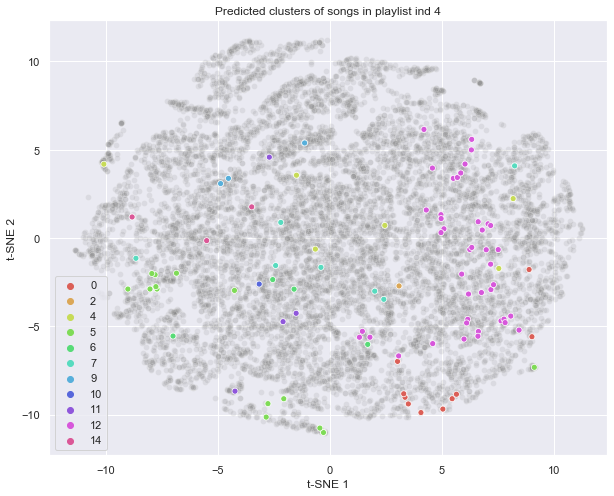

In [174]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[tsne_ind, 0], 
    y = tsne_results[tsne_ind, 1],
    #hue = k_labels[tsne_ind],
    #palette = sns.color_palette("hls", len(np.unique(k_labels[tsne_ind]))),
    legend = "full",
    color = 'grey',
    alpha = 0.15
)

ax = sns.scatterplot(
    x = tsne_results[list(np.argwhere(indicators[:, 4].A.reshape((-1,)) == 1).reshape((-1,))), 0], 
    y = tsne_results[list(np.argwhere(indicators[:, 4].A.reshape((-1,)) == 1).reshape((-1,))), 1],
    hue = k_labels[list(np.argwhere(indicators[:, 4].A.reshape((-1,)) == 1).reshape((-1,)))],
    palette = sns.color_palette("hls", len(np.unique(k_labels[list(np.argwhere(indicators[:, 4].A.reshape((-1,)) == 1).reshape((-1,)))]))),
    legend = "full",
    alpha = 1
)

ax.set(title = 'Predicted clusters of songs in playlist ind 4', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')

plt.savefig('playlist_songs_clusters.pdf'.format(time.time()))

In assessing the above sample single playlist, we see that t-SNE represents the geographic distribution as being fairly random, with a potential overall skew towards the bottom right of the graph. But in applying the K-Means cluster label as a color code, we see that for this playlist, half of the songs are in a single cluster 12 with another fifth in each of clusters 7, 5 and 0. This appears much more promising for playlist generation! K-Means has found a relative connection between songs presumed to be similar (since they belong to the same playlist in our original dataset).

In [701]:
pickle.dump(kmeans, open('../data/final/kmeans_model.pkl', 'wb'))
# Load model later with:
#flerp = pickle.load(open('../data/final/kmeans_model.pkl', 'rb'))
#flerp.predict(encoded_cont[0:1, :])

In [685]:
np.save('../data/final/kmeans_labels', kmeans.labels_)
# Load later with:
#derp = np.load('../data/final/kmeans_labels.npy', allow_pickle = True)

# Generating a Cold-Start Playlist

After dimension reductionality and testing multiple different clustering mechanisms, we move to the challenge of generating and assessing our own playlist from a small selection of seed songs.

We focused on using continuous features of each song (tempo, danceability, etc.) passed through dimensionality reduction and grouped using K-Means relative clustering. After arriving at a set of workable clusters for song selection, we then seed our generated playlist with a handful of manually selected songs. Our algorithm will take each seed song, identify the cluster that it belongs to and select a song from that cluster using a representative derived distance metric. It will repeat this until the desired song count has been reached.

#### Overview of playlist generation model:

- Using an autoencoder, we reduce dimensionality of song characteristics (tempo, valence, etc.).

- Using K-Means, we find clusters of songs based on the salient features identified by the autoencoder.

- Given a set seed songs, we identify the clusters to build playlist from.

- We find pairwise cosine distances between seed songs and every other song in the cluster.

- Finally, we generate the playlist with songs that are most similar (least cosine distance) to the seed songs.


#### Key notes:

- We did not use any artist or album information in the final model. Our model generated clusters solely based on song characteristics we pulled from the Spotify API.

- We defined similarity of songs as the co-occurance of songs in the original playlists in our dataset. We assume that these original playlists have songs that belong together as identified by Spotify users. 

- We are able to generate pairwise coside distances across the whole cluster without high computational cost because we were able to create the sparse matrix. Each row in the sparse matrix represents a song, each column represents a playlist, and each value is a binary whether the given song (row) occurs in the given playlist (column).

- The values that we clustered on are outputs from the autoencoder. The magnitude of these are difficult to interpret and as such as do not have much meaning. As such, we chose to use cosine distances rather than Euclidean distances.

In [2]:
'''
Function to generate a new playlist based on a set of starting songs.
Returns the list of song IDs in the generated playlist, including those of the seed songs.
Requires a fitted clusterer with which to predict the label of seed songs and pull from set.
'''
def generate_playlist(seed_song_ids, playlist_length, clusterer):
    # Start with seed songs, those are included too
    new_song_ids = seed_song_ids.copy()

    while len(new_song_ids) < playlist_length:
        # Pick a seed song at random
        seed_id = np.random.choice(seed_song_ids)
        # Find index in dataset of seed song
        seed_ind = np.argwhere(song_ids == seed_id)[0][0]
        # Predict cluster of seed song
        seed_clust = clusterer.predict(encoded_cont[seed_ind, :].reshape((1,-1)))[0]
        # Get indices of all songs in that cluster
        clust_inds = np.argwhere(clusterer.labels_ == seed_clust).reshape((-1,))
        # Calculate playlist co-occurrence cosine distance between seed and all songs in same cluster
        clust_seed_dist = cosine_distances(indicators[clust_inds], indicators[seed_ind]).reshape((-1,))
        # Sort indices of songs by distance to seed (co-occurrence)
        closest_songs_ind = np.argsort(clust_seed_dist)
        # Get the song IDs corresponding to those songs
        closest_songs_ids = song_ids[clust_inds][closest_songs_ind]

        # Find first of closest songs that is not already in new playlist
        # Can stop iterator at playlist length: if true that far, playlist is full anyway
        closest_songs_in_playlist = [sid in new_song_ids for sid in closest_songs_ids]

        new_song_ids.append(closest_songs_ids[np.argmin(closest_songs_in_playlist)])
    
    # Return song IDs of generated playlist (including seed songs)
    return new_song_ids

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import scipy.sparse
import time
import pickle
sns.set()

# Load model:
kmeans_model = pickle.load(open('../data/kmeans_model.pkl', 'rb'))
#flerp.predict(encoded_cont[0:1, :])

# Load labels:
labels = np.load('../data/kmeans_labels.npy', allow_pickle = True)

In [1]:
p_id = 0

playlist = indicators[:, p_id].A.reshape((-1,))

playlist_song_ind = list(np.argwhere(playlist == 1).reshape((-1,)))

playlist_song_ids = list(song_ids[playlist_song_ind].reshape((-1,)))
playlist_song_ids

In [547]:
playlist_song_clust = kmeans.labels_[playlist_song_ind]
playlist_song_clust

array([12,  0, 12, 12, 12,  5,  5,  0,  6, 12, 12, 12], dtype=int32)

In [550]:
new_playlist = generate_playlist(playlist_song_ids[0:6], 100, kmeans)

### Our first generated playlist

In order to test our playlist, we wanted to see, when provided with a few seed songs from a specific existing playlist, whether our generation algorithm would produce a playlist close to the seed playlist. From our generation algorithm, we then produced the below playlist (10 random songs shown out of 100).

In [536]:
# Inspect our new playlist
master.loc[new_song_ids].head(10)

artist_name                             artist_uri  \
song_id                                                                   
125250          Rachael Yamagata  spotify:artist:7w0qj2HiAPIeUcoPogvOZ6   
787744                 Glee Cast  spotify:artist:0SCbttzoZTnLFebDYmAWCm   
340039          Sleeping At Last  spotify:artist:0MeLMJJcouYXCymQSHPn8g   
603984                   Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
461894             Mayday Parade  spotify:artist:3WfJ1OtrWI7RViX9DMyEGy   
653897   The Cinematic Orchestra  spotify:artist:32ogthv0BdaSMPml02X9YB   
834653                   Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
180192             Mayday Parade  spotify:artist:3WfJ1OtrWI7RViX9DMyEGy   
994457             Mayday Parade  spotify:artist:3WfJ1OtrWI7RViX9DMyEGy   
468524                   Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   

                                         track_name  \
song_id                                               
125250                                    Elephants   
787744   Somewhere Only We Know (Glee Cast Version)   
340039                                 Chasing Cars   
603984                                 Close To You   
461894                              Terrible Things   
653897                              To Build A Home   
834653                                 Never Ending   
180192                            Miserable At Best   
994457                                    Your Song   
468524                                  James Joint   

                                    album_uri  duration_ms  \
song_id                                                      
125250   spotify:album:6KzK9fDNmj7GHFbcE4gVJD       253701   
787744   spotify:album:6WlzaRoDShdgVgaqJRjyNH       184653   
340039   spotify:album:0UIIvTTWNB3gRQWFoxoEDh       242564   
603984   spotify:album:3Q149ZH46Z0f3oDR7vlDYV       223226   
461894   spotify:album:4eVvdwd6AC7nh9TvJD9XyT       238076   
653897   spotify:album:5cPHT4yMCfETLRYAoBFcOZ       371320   
834653   spotify:album:3Q149ZH46Z0f3oDR7vlDYV       202506   
180192   spotify:album:0UtenXp3qVbWedKEaNRAp9       316986   
994457   spotify:album:4eVvdwd6AC7nh9TvJD9XyT       249338   
468524   spotify:album:3Q149ZH46Z0f3oDR7vlDYV        72080   

                                       album_name  count  \
song_id                                                    
125250       Elephants...Teeth Sinking Into Heart     14   
787744   Glee: The Music, The Complete Season Two     86   
340039                             Covers, Vol. 2    401   
603984                                       ANTI    500   
461894                                Valdosta EP    339   
653897                                   Ma Fleur   1593   
834653                                       ANTI    277   
180192                      A Lesson In Romantics    619   
994457                                Valdosta EP     41   
468524                                       ANTI    207   

                                    track_uri  danceability  energy  ...  \
song_id                                                              ...   
125250   spotify:track:0y4TKcc7p2H6P0GJlt01EI         0.312   0.207  ...   
787744   spotify:track:66mmvchQ4C3LnPzq4DiAI3         0.493   0.552  ...   
340039   spotify:track:2d7LPtieXdIYzf7yHPooWd         0.467   0.157  ...   
603984   spotify:track:4gFxywaJejXWxo0NjlWzgg         0.494   0.170  ...   
461894   spotify:track:3ZjnFYlal0fXN6t61wdxhl         0.285   0.371  ...   
653897   spotify:track:54KFQB6N4pn926IUUYZGzK         0.264   0.122  ...   
834653   spotify:track:6TTtJwtPEAI7yPHKR3XEKE         0.530   0.391  ...   
180192   spotify:track:1ONoPkp5XIuw3tZ1GzrNKZ         0.464   0.362  ...   
994457   spotify:track:7va0FN5Fim1dNPi06sqxVx         0.422   0.459  ...   
468524   spotify:track:3cuGpP8vUSC1aq8tjD3J2c         0.399   0.203  ...   

         instrumentalness  liveness  valence    tempo  time_signature  \
song_id

Manually reviewing 10 songs from our generated playlist shows artist overlap for Rihanna and Mayday Parade, indicating that our clustering algorithm is actually identifying the same artist extremely well from just 5 musical features! To further assess the clustering of the whole playlist, we charted our generated playlist in t-SNE space.

In [537]:
new_songs_ind = [list(song_ids).index(sid) for sid in new_playlist]

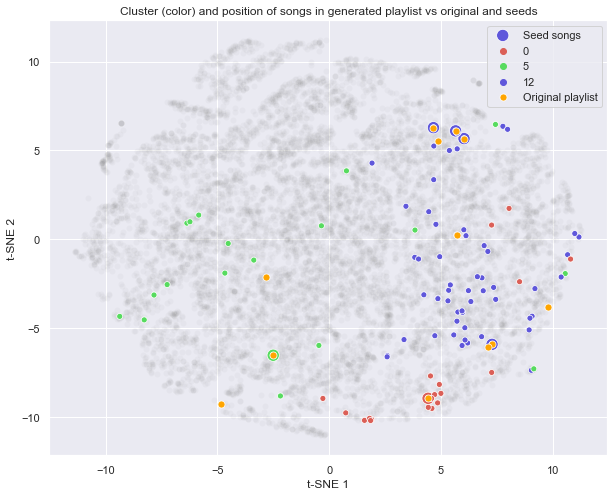

In [538]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[tsne_ind, 0], 
    y = tsne_results[tsne_ind, 1],
    color = 'grey',
    alpha = 0.05
)

ax = sns.scatterplot(
    x = tsne_results[new_songs_ind[0:6], 0], 
    y = tsne_results[new_songs_ind[0:6], 1],
    hue = kmeans.labels_[new_songs_ind[0:6]],
    palette = sns.color_palette("hls", len(np.unique(kmeans.labels_[new_songs_ind[0:6]]).reshape((-1,)))),
    #edgecolor = 'orange',
    alpha = 1,
    legend = None,
    label = 'Seed songs',
    s = 150
)

ax = sns.scatterplot(
    x = tsne_results[new_songs_ind, 0], 
    y = tsne_results[new_songs_ind, 1],
    hue = kmeans.labels_[new_songs_ind],
    palette = sns.color_palette("hls", len(np.unique(kmeans.labels_[new_songs_ind]).reshape((-1,)))),
    legend = "full",
    alpha = 1
)

ax = sns.scatterplot(
    x = tsne_results[playlist_song_ind, 0], 
    y = tsne_results[playlist_song_ind, 1],
    color = 'orange',
    #legend = None,
    label = 'Original playlist',
    alpha = 1,
    s = 50
)

ax.set(title = 'Cluster (color) and position of songs in generated playlist vs original and seeds', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')

plt.savefig('generated_playlist_0.pdf'.format(time.time()))

Our t-SNE graph shows the seed songs that were selected from the manually-curated playlist as the largest bubbles. All songs in the original manual playlist are highlighted in gold. Our generated songs that were not in the original playlist are colored according to the cluster that our algorithm assigns them to. For our generated playlist, we see that a fifth of songs overlap with the original seed playlist but beyond that we have fairly solid generated results within three clusters, all of which are approximately similar in t-SNE space location as well.

Combined with our manual review of the generated songs, we can develop some confidence that our algorithm is producing the start of a thematically similar generated playlist!

Our algorithm clustered together Rihanna even though we did not provide any artist / album information. Furthermore, other Rihanna songs were identified as "similar" songs and added to the generated playlist.

We tried this on several randomly selected playlists and saw some encouraging results, including several examples where generated songs had a majority overlap with the original seed playlist. We've included one such example below. Though this example has a greater number of non-overlap clusters than our first, it also shows that the majority of songs overlapped between the generated and seed playlists. 

One area of further study we would like to pursue would be researching the balance between overlap percentage and cluster proliferation to understand if our generation algorithm sees an exclusive or dependent relationship between these two optimizations.

In [622]:
p_id = 1

playlist = indicators[:, p_id].A.reshape((-1,))

playlist_song_ind = list(np.argwhere(playlist == 1).reshape((-1,)))

playlist_song_ids = list(song_ids[playlist_song_ind].reshape((-1,)))

In [623]:
new_playlist_1 = generate_playlist(playlist_song_ids[0:10], 100, kmeans)

In [624]:
new_songs_ind = [list(song_ids).index(sid) for sid in new_playlist_1]

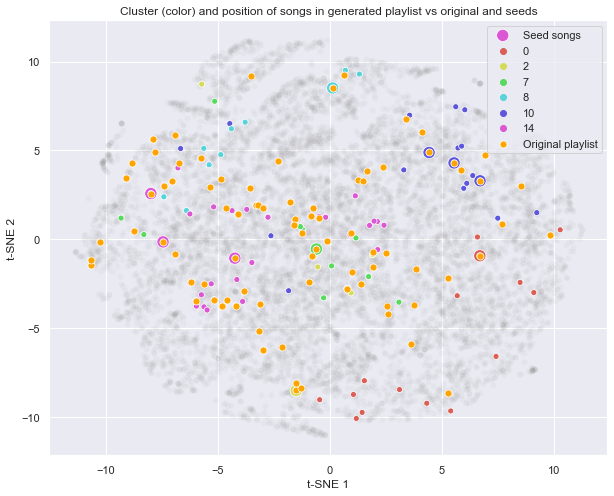

In [625]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[tsne_ind, 0], 
    y = tsne_results[tsne_ind, 1],
    color = 'grey',
    alpha = 0.05
)

ax = sns.scatterplot(
    x = tsne_results[new_songs_ind[0:10], 0], 
    y = tsne_results[new_songs_ind[0:10], 1],
    hue = kmeans.labels_[new_songs_ind[0:10]],
    palette = sns.color_palette("hls", len(np.unique(kmeans.labels_[new_songs_ind[0:10]]).reshape((-1,)))),
    #edgecolor = 'orange',
    alpha = 1,
    legend = None,
    label = 'Seed songs',
    s = 150
)

ax = sns.scatterplot(
    x = tsne_results[new_songs_ind, 0], 
    y = tsne_results[new_songs_ind, 1],
    hue = kmeans.labels_[new_songs_ind],
    palette = sns.color_palette("hls", len(np.unique(kmeans.labels_[new_songs_ind]).reshape((-1,)))),
    legend = "full",
    alpha = 1
)

ax = sns.scatterplot(
    x = tsne_results[playlist_song_ind, 0], 
    y = tsne_results[playlist_song_ind, 1],
    color = 'orange',
    #legend = None,
    label = 'Original playlist',
    alpha = 1,
    s = 50
)

ax.set(title = 'Cluster (color) and position of songs in generated playlist vs original and seeds', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')

plt.savefig('generated_playlist_1.pdf'.format(time.time()))

Visual analysis of our cold-start generated playlists showed encouraging results but we wanted to layer on a more quantitative measure of success as well. To do this, we continue to rely on the assumption that manually-curated playlists can be considered "high quality" due to the understanding that someone spent the time and effort to put songs that they wanted to listen to together.

Given that assumption, we can use a derived distance calculation between a generated playlist and the library of manually-curated playlists to assess absolute or relative quality. We posit that if an algorithmically generated playlist has a low distance to a manually curated playlist, regardless of starting seed songs, then it can be considered a well-generated playlist. This distance metric is especially true when calculating the absolute quality between a generated playlist and a playlist it is specifically seeded from, such as in our earlier examples.

One critical design choice we made is that of setting a minimum threshold of song count for playlist inclusion. Because a manual playlist with few songs is likelier, by the fact that it has only a few datapoints, to appear a match or measure a low distance to a generated playlist, it represents an unfair comparison of success.

We present another randomly selected playlist as an example of our distance quality metric.

In [637]:
p_id = 0

playlist = indicators[:, p_id].A.reshape((-1,))

playlist_song_ind = list(np.argwhere(playlist == 1).reshape((-1,)))

playlist_song_ids = list(song_ids[playlist_song_ind].reshape((-1,)))

In [638]:
new_playlist = generate_playlist(playlist_song_ids[0:5], len(playlist_song_ids), kmeans)

In [639]:
new_songs_ind = [list(song_ids).index(sid) for sid in new_playlist]

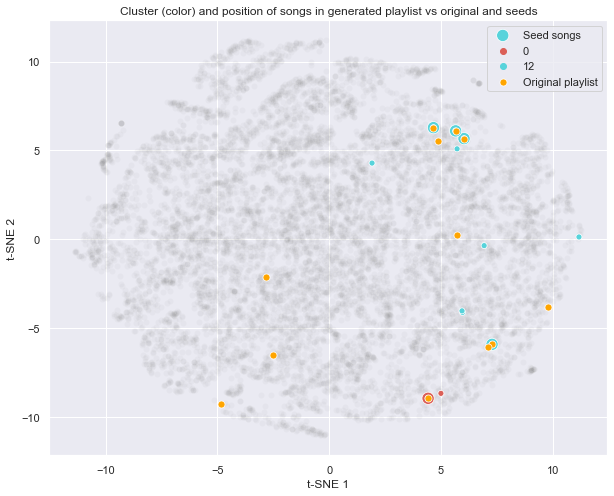

In [640]:
plt.figure(figsize=(10, 8))

ax = sns.scatterplot(
    x = tsne_results[tsne_ind, 0], 
    y = tsne_results[tsne_ind, 1],
    color = 'grey',
    alpha = 0.05
)

ax = sns.scatterplot(
    x = tsne_results[new_songs_ind[0:5], 0], 
    y = tsne_results[new_songs_ind[0:5], 1],
    hue = kmeans.labels_[new_songs_ind[0:5]],
    palette = sns.color_palette("hls", len(np.unique(kmeans.labels_[new_songs_ind[0:10]]).reshape((-1,)))),
    #edgecolor = 'orange',
    alpha = 1,
    legend = None,
    label = 'Seed songs',
    s = 150
)

ax = sns.scatterplot(
    x = tsne_results[new_songs_ind, 0], 
    y = tsne_results[new_songs_ind, 1],
    hue = kmeans.labels_[new_songs_ind],
    palette = sns.color_palette("hls", len(np.unique(kmeans.labels_[new_songs_ind]).reshape((-1,)))),
    legend = "full",
    alpha = 1
)

ax = sns.scatterplot(
    x = tsne_results[playlist_song_ind, 0], 
    y = tsne_results[playlist_song_ind, 1],
    color = 'orange',
    #legend = None,
    label = 'Original playlist',
    alpha = 1,
    s = 50
)

ax.set(title = 'Cluster (color) and position of songs in generated playlist vs original and seeds', 
       xlabel = 't-SNE 1', ylabel = 't-SNE 2')

plt.savefig('generated_playlist_same_length.pdf'.format(time.time()))

#### Calculate distance to human-created playlists and manually inspect the closest-matching

In [641]:
# Create songs-in-playlist indicator vector for our generated playlist
indicators_generated = np.zeros((1, indicators.shape[0]))
indicators_generated[0, new_songs_ind] = 1

In [642]:
playlist_dists = cosine_distances(indicators.T, indicators_generated).reshape((-1,))

In [643]:
# Get song indicators of the 5 closest playlists to the one we generated
sorted_playlists = indicators[:, np.argsort(playlist_dists)[0:5]]

In [644]:
np.sort(closest_playlists)[0:5]

array([0.71711053, 0.73299937, 0.76201676, 0.7628821 , 0.76480988])

Our closest playlists calculations provide us scores for the five nearest playlists of between 0.717 and 0.765, a coefficient estimate that we can use to compare playlists overall and between each other. To conclude, we manually review songs in each playlist to see if our distance coefficient holds up.

#### Generated playlist

In [648]:
master.loc[song_ids[new_songs_ind]]

artist_name                             artist_uri  \
song_id                                                            
125250   Rachael Yamagata  spotify:artist:7w0qj2HiAPIeUcoPogvOZ6   
787744          Glee Cast  spotify:artist:0SCbttzoZTnLFebDYmAWCm   
340039   Sleeping At Last  spotify:artist:0MeLMJJcouYXCymQSHPn8g   
603984            Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
461894      Mayday Parade  spotify:artist:3WfJ1OtrWI7RViX9DMyEGy   
834653            Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
772125   Sleeping At Last  spotify:artist:0MeLMJJcouYXCymQSHPn8g   
521562              Stars  spotify:artist:2EO56JK4txid1Pss9GVbOL   
195814          Glee Cast  spotify:artist:0SCbttzoZTnLFebDYmAWCm   
468524            Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
541794      A Fine Frenzy  spotify:artist:5dTYaRzOn4rXGBLH052EeQ   
460009            Camille  spotify:artist:0gOsZcHl7H3ewXVIEnWFZX   

                                         track_name  \
song_id                                               
125250                                    Elephants   
787744   Somewhere Only We Know (Glee Cast Version)   
340039                                 Chasing Cars   
603984                                 Close To You   
461894                              Terrible Things   
834653                                 Never Ending   
772125                                 Already Gone   
521562                                     Personal   
195814                  Fix You (Glee Cast Version)   
468524                                  James Joint   
541794                                    Riversong   
460009                   Pour que l'amour me quitte   

                                    album_uri  duration_ms  \
song_id                                                      
125250   spotify:album:6KzK9fDNmj7GHFbcE4gVJD       253701   
787744   spotify:album:6WlzaRoDShdgVgaqJRjyNH       184653   
340039   spotify:album:0UIIvTTWNB3gRQWFoxoEDh       242564   
603984   spotify:album:3Q149ZH46Z0f3oDR7vlDYV       223226   
461894   spotify:album:4eVvdwd6AC7nh9TvJD9XyT       238076   
834653   spotify:album:3Q149ZH46Z0f3oDR7vlDYV       202506   
772125   spotify:album:0UIIvTTWNB3gRQWFoxoEDh       243007   
521562   spotify:album:4I9BDOOxpLw2ClFDRhTJaN       247173   
195814   spotify:album:082BH67sSIDefLxUp8GgNm       274760   
468524   spotify:album:3Q149ZH46Z0f3oDR7vlDYV        72080   
541794   spotify:album:0jW4xokRXUFjI2lQEiYW5j       466367   
460009   spotify:album:1AY69raETX2k8Y2zCfIhuI       166720   

                                         album_name  count  \
song_id                                                      
125250         Elephants...Teeth Sinking Into Heart     14   
787744     Glee: The Music, The Complete Season Two     86   
340039                               Covers, Vol. 2    401   
603984                                         ANTI    500   
461894                                  Valdosta EP    339   
834653                                         ANTI    277   
772125                               Covers, Vol. 2    253   
521562                 In Our Bedroom After The War     17   
195814   Glee: The Music, The Complete Season Three     23   
468524                                         ANTI    207   
541794                                        PINES      5   
460009                                       Le fil      5   

                                    track_uri  danceability  energy  ...  \
song_id                                                              ...   
125250   spotify:track:0y4TKcc7p2H6P0GJlt01EI         0.312  0.2070  ...   
787744   spotify:track:66mmvchQ4C3LnPzq4DiAI3         0.493  0.5520  ...   
340039   spotify:track:2d7LPtieXdIYzf7yHPooWd         0.467  0.1570  ...   
603984   spotify:track:4gFxywaJejXWxo0NjlWzgg         0.494  0.1700  ...   
461894   spotify:track:3ZjnFYlal0fXN6t61wdxhl         0.285  0.3710  ...   
834653   spotify:tra

#### Closest matching

In [684]:
master.loc[song_ids[np.argwhere(sorted_playlists[:, 0].A.flatten() == 1)].flatten()]

artist_name                             artist_uri  \
song_id                                                                   
125250          Rachael Yamagata  spotify:artist:7w0qj2HiAPIeUcoPogvOZ6   
787744                 Glee Cast  spotify:artist:0SCbttzoZTnLFebDYmAWCm   
340039          Sleeping At Last  spotify:artist:0MeLMJJcouYXCymQSHPn8g   
603984                   Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
461894             Mayday Parade  spotify:artist:3WfJ1OtrWI7RViX9DMyEGy   
653897   The Cinematic Orchestra  spotify:artist:32ogthv0BdaSMPml02X9YB   
881533   The Cinematic Orchestra  spotify:artist:32ogthv0BdaSMPml02X9YB   
894661              Shawn Mendes  spotify:artist:7n2wHs1TKAczGzO7Dd2rGr   
810569              Josef Salvat  spotify:artist:64PJHZDQTPPVBCdwnv22Wz   
49614               Leon Bridges  spotify:artist:3qnGvpP8Yth1AqSBMqON5x   
776037                      nilu  spotify:artist:1XplrA4Q9dPFcayYbJqX6K   
356319               Ryan Amador  spotify:artist:1ihU4zSTmY0qQXhx8jEXWT   

                                         track_name  \
song_id                                               
125250                                    Elephants   
787744   Somewhere Only We Know (Glee Cast Version)   
340039                                 Chasing Cars   
603984                                 Close To You   
461894                              Terrible Things   
653897                              To Build A Home   
881533                                    That Home   
894661                               Never Be Alone   
810569                                     Diamonds   
49614                                         River   
776037                           How to Save a Life   
356319                                      Instead   

                                    album_uri  duration_ms  \
song_id                                                      
125250   spotify:album:6KzK9fDNmj7GHFbcE4gVJD       253701   
787744   spotify:album:6WlzaRoDShdgVgaqJRjyNH       184653   
340039   spotify:album:0UIIvTTWNB3gRQWFoxoEDh       242564   
603984   spotify:album:3Q149ZH46Z0f3oDR7vlDYV       223226   
461894   spotify:album:4eVvdwd6AC7nh9TvJD9XyT       238076   
653897   spotify:album:5cPHT4yMCfETLRYAoBFcOZ       371320   
881533   spotify:album:5cPHT4yMCfETLRYAoBFcOZ       103920   
894661   spotify:album:5wKylB0Zwnxz046O7po25D       215813   
810569   spotify:album:1excMWyBjh9UJqk2xYZ7o0       247600   
49614    spotify:album:4svLfrPPk2npPVuI4kXPYg       238560   
776037   spotify:album:3JymwO9er7CrAoJULoogfq       262500   
356319   spotify:album:1t1kSv0ySypwFXKgyocRRk       355529   

                                       album_name  count  \
song_id                                                    
125250       Elephants...Teeth Sinking Into Heart     14   
787744   Glee: The Music, The Complete Season Two     86   
340039                             Covers, Vol. 2    401   
603984                                       ANTI    500   
461894                                Valdosta EP    339   
653897                                   Ma Fleur   1593   
881533                                   Ma Fleur    121   
894661                                Handwritten    626   
810569                                 Night Swim     44   
49614                                 Coming Home    989   
776037                         How to Save a Life     59   
356319                                Ryan Amador    117   

                                    track_uri  danceability  energy  ...  \
song_id                                                              ...   
125250   spotify:track:0y4TKcc7p2H6P0GJlt01EI         0.312  0.2070  ...   
787744   spotify:track:66mmvchQ4C3LnPzq4DiAI3         0.493  0.5520  ...   
340039   spotify:track:2d7LPtieXdIYzf7yHPooWd         0.467  0.1570  ...   
603984   spotify:track:4gFxywaJejXWxo0NjlWzgg         0.494  0.1700  ...   
461894   spotify:track:3ZjnFYlal0

#### 2nd closest matching

In [699]:
master.loc[song_ids[np.argwhere(sorted_playlists[:, 1].A.flatten() == 1)].flatten()]

artist_name                             artist_uri  \
song_id                                                        
8489          Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
68416         Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
191443        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
199776        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
310316        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
335121        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
468524        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
603984        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
613612        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
815849        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
834653        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
953321        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
138902        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
343268        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
371613        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
840310        Rihanna  spotify:artist:5pKCCKE2ajJHZ9KAiaK11H   
974881   XXXTENTACION  spotify:artist:15UsOTVnJzReFVN1VCnxy4   
793792         Kensho  spotify:artist:2jcxsN1wOb2HO7Z2AGdjN3   

                track_name                             album_uri  duration_ms  \
song_id                                                                         
8489     Same Ol’ Mistakes  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       397093   
68416        Consideration  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       161066   
191443           Needed Me  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       191600   
199776              Higher  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       120626   
310316                 Woo  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       235586   
335121   Love On The Brain  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       224000   
468524         James Joint  spotify:album:3Q149ZH46Z0f3oDR7vlDYV        72080   
603984        Close To You  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       223226   
613612     Yeah, I Said It  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       133080   
815849           Desperado  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       186466   
834653        Never Ending  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       202506   
953321      Kiss It Better  spotify:album:3Q149ZH46Z0f3oDR7vlDYV       253080   
138902                Work  spotify:album:2JNVoEx4psIgNQyEExwQVn       219320   
343268                Pose  spotify:album:19O3rXe4nDu9YDcc2tOQVn       144226   
371613    Goodnight Gotham  spotify:album:19O3rXe4nDu9YDcc2tOQVn        88493   
840310         Sex With Me  spotify:album:19O3rXe4nDu9YDcc2tOQVn       206400   
974881      Jocelyn Flores  spotify:album:5VdyJkLe3yvOs0l4xXbWp0       119133   
793792   Breathe & Receive  spotify:album:6wm4ibWe3YQlLG7Azx1IU9       140184   

                album_name  count                             track_uri  \
song_id                                                                   
8489                  ANTI    433  spotify:track:046irIGshCqu24AjmEWZtr   
68416                 ANTI    692  spotify:track:0WgBb7XgdtbUW0GlYel9mH   
191443                ANTI   5369  spotify:track:1Tt4sE4pXi57mTD1GCzsqm   
199776                ANTI    590  spotify:track:1XrrzhGLErbkiwH5v3xww9   
310316                ANTI    260  spotify:track:2OvftP4F7VMMTdfyUx883s   
335121                ANTI   3073  spotify:track:2aksifNn5ph8igDOkPBA02   
468524                ANTI    207  spotify:track:3cuGpP8vUSC1aq8tjD3J2c   
603984                ANTI    500  spotify:track:4gFxywaJejXWxo0NjlWzgg   
613612                ANTI    559  spotify:track:4kqxy0SvQ2N34nOJ9ggfMu   
815849                ANTI   1144  spotify:track:6KFaHC9G178beAp7P0Vi5S   
834653                ANTI    277  spotify:track:6TTtJwtPEAI7yPHKR3XEKE   
953321                ANTI   1033  spotify:track:7bmqcI1HQwx1PWwYyZO0lg   
138902                ANTI   4683  spotify:track:14WWzenpa

# Generating Our Playlist and the Lessons Learned

We started off with the goal of generating a thematic and enjoyable playlist from a cold start, meaning having only a few seed songs that we can derive a theme from. Our starting data was a large sample of manually curated playlists and the songs in each. From there, we were able to leverage the Spotify API to enrich our song metadata with features about the inherent nature of each song, including features like tempo, danceability, variance and more. This metadata meant that we could begin to explore the defining characteristics of a song and how families of songs related to each other.

To do this, we took our enriched continuous features and expanded our categorical features to the fullest extent, applying dimensionality reduction techniques to try to distill what about each song proved most important in defining families and relationships. We tested several techniques trying to successfully expand and use categoricals for artist and album but ultimately came to the conclusion that applying an AutoEncoder neural network to just our continuous features was the best path forward.

Songs with dimensions reduced to the remaining critical features were then passed through multiple variations of clustering techniques to see which was better able to separate related families of songs. HDBSCAN, the more complex and high-powered algorithm, failed to produce a sufficient number of distinct clusters for use in our recommendation algorithm because it considered "noise" as a first-order principle and most songs are similar enough in their core musical attributes to prevent styles rising above the density threshold. K-Means proved more practically useful for recommendation as it forced separation to a manually defined number of clusters and assessed song similarity on a relative basis, a technique that aligns better to song styles. Projecting both clustering techniques on a t-SNE graph enabled a form of standardized assessment, though it complicated interpretability by reducing the number of dimensions the algorithms were considering to just the two required for plotting.

With our important features identified and the most effective clustering technique chosen, we constructed a playlist generation algorithm that allowed a user to select a handful of seed songs and produce a playlist comprised of songs from the same advanced clusters. Visual analysis indicated promising returns when looking at overlapping songs between a generated playlist and a manually curated seed playlist.

In order to improve upon our visual analysis, we invented a playlist similarity coefficient defined by a distance metric between generated playlists and any manually curated one. We used this similarity coefficient to compare generated playlists to curated ones and saw examples of the closest playlists having similar artists and genres to our generated ones. We believe this shows that our model is succeeding in generating thematic playlists from a cold start and the musical features of the songs provided.

# Further Development

Our first improvement would be to change the song selection mechanism from an identified cluster during generation. Currently, we select songs from the same cluster as our seed songs, based on a distance score calculated from just a randomly selected seed song. Instead, we would like to expand the list of songs we randomly select from to include the songs we are adding during the generation process. This would ensure a little more variety of selection because we wouldn't be just calculating distance from the seed songs, but from the seed song plus the songs already added.

Our second improvement would be to better identify a unique genre for each song or album and deploy that as a feature. Genre classifications vary but are a human's manual assessment for the type of song. Including this as a feature would be complicated because we would need to define a method to select a "primary genre" from the provided list as well as generate a genre for the majority of songs without one but could provide a great leap in cluster identification.

One insight that cannot be ignored is that most songs can not be differentiated into distinct families by their musical features on an absolute basis. Only a few clusters, all small in size, passed the density threshold of HDBSCAN to be identified. This suggests that further improvement and personalization based on inherent qualities of each song are unlikely to come.

Instead, we would want to move to analysis of the social graph. Underlying our recommendation modeling was the assumption that manually curated playlists should be considered high quality because someone invested time and effort into it. It represents their stated preference. Similarly, we can use people's listening history to represent their unstated preferences and infer that if you are listening to a song, you enjoy it. Further, if one person has listened to these 100 songs and a second person has also listened to 30 of the same songs, they would likely enjoy the remaining 70. Integrating user listening history in this way would allow us to deploy our clustering techniques and produce user preference profiles from which we can pull songs to generate new playlists instead of or in addition to our musical features clusters.

If we wanted to improve our recommendations based solely on musical features of the song itself, we would recommend integrating digital health data into the algorithm and regressing the tempo or energy of a song with a health metric such as heart rate at the time of listening. This would enable us to identify families of songs that match at various biological frequencies and generate playlists of songs for that pace. Playlists are a new musical consumption style in that they are meant to last an hour or longer and should provide a user with a continuous auditory sensation for that period of time. They differ from the album format in that an album is designed to be a journey directed by the artist, to take the listener through a designed experience. Playlists are meant to match exclusively to mood, making the potential integration of digital health data an exciting avenue of exploration.

# Reference Articles

We designed our model from first-principles following our exploratory analysis of the data. Our chosen techniques and the successful implementation of them benefited greatly from various online resources, the most significant of which we've included below.

---

McInnes, Leland, John Healy, Steve Astels (2016). **The hdbscan Clustering Library**. Retrieved from https://hdbscan.readthedocs.io/en/latest/

Shaikh, Faizan (2018, May). **Essentials of Deep Learning: Introduction to Unsupervised Deep Learning (with Python codes)**. Retrieved from https://www.analyticsvidhya.com/blog/2018/05/essentials-of-deep-learning-trudging-into-unsupervised-deep-learning/

Chengwei (2018, June). **How to do Unsupervised Clustering with Keras**. Retrieved from https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/

Pagels, Max (2017, December). **Introducing One of the Best Hacks in Machine Learning: the Hashing Trick**. Retrieved from https://medium.com/value-stream-design/introducing-one-of-the-best-hacks-in-machine-learning-the-hashing-trick-bf6a9c8af18f

Derksen, Luuk (2016, October). **Visualising high-dimensional datasets using PCA and t-SNE in Python**. Retrieved from https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

---